# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite` with a dash or an underscore, so take note and make sure the below `image_dir` accordingly. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

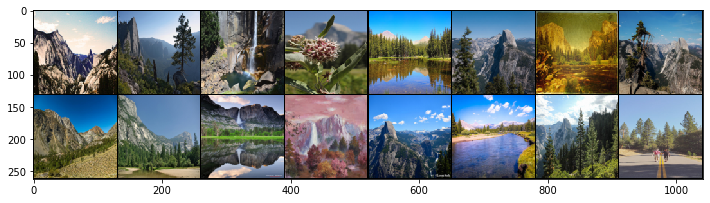

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

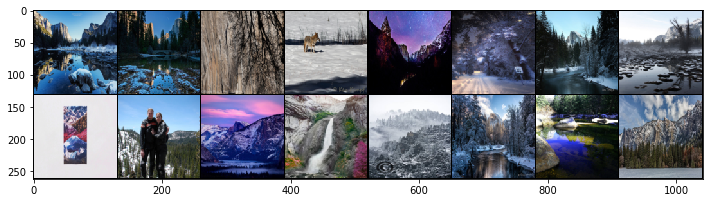

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0078)
Max:  tensor(0.9569)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9843)
Scaled max:  tensor(0.9137)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 8000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 8000] | d_X_loss: 0.3970 | d_Y_loss: 0.4836 | g_total_loss: 9.7555
Epoch [   20/ 8000] | d_X_loss: 0.2739 | d_Y_loss: 0.2728 | g_total_loss: 8.2928
Epoch [   30/ 8000] | d_X_loss: 0.4247 | d_Y_loss: 0.6023 | g_total_loss: 6.7732
Epoch [   40/ 8000] | d_X_loss: 0.3264 | d_Y_loss: 0.6852 | g_total_loss: 5.5479
Epoch [   50/ 8000] | d_X_loss: 0.4963 | d_Y_loss: 0.3403 | g_total_loss: 5.7676
Epoch [   60/ 8000] | d_X_loss: 0.2518 | d_Y_loss: 0.2557 | g_total_loss: 6.4945
Epoch [   70/ 8000] | d_X_loss: 0.2235 | d_Y_loss: 0.4964 | g_total_loss: 5.3525
Epoch [   80/ 8000] | d_X_loss: 0.3433 | d_Y_loss: 0.3987 | g_total_loss: 4.9993
Epoch [   90/ 8000] | d_X_loss: 0.5968 | d_Y_loss: 0.4008 | g_total_loss: 5.0598


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 8000] | d_X_loss: 0.4596 | d_Y_loss: 0.5464 | g_total_loss: 4.7812
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 8000] | d_X_loss: 0.4651 | d_Y_loss: 0.4217 | g_total_loss: 5.0760
Epoch [  120/ 8000] | d_X_loss: 0.3820 | d_Y_loss: 0.7986 | g_total_loss: 4.3483
Epoch [  130/ 8000] | d_X_loss: 0.2497 | d_Y_loss: 0.5395 | g_total_loss: 4.5045
Epoch [  140/ 8000] | d_X_loss: 0.4415 | d_Y_loss: 0.5603 | g_total_loss: 4.3581
Epoch [  150/ 8000] | d_X_loss: 0.6235 | d_Y_loss: 0.3994 | g_total_loss: 4.8738
Epoch [  160/ 8000] | d_X_loss: 0.5213 | d_Y_loss: 0.4087 | g_total_loss: 4.1294
Epoch [  170/ 8000] | d_X_loss: 0.4575 | d_Y_loss: 0.3564 | g_total_loss: 4.4999
Epoch [  180/ 8000] | d_X_loss: 0.3884 | d_Y_loss: 0.3412 | g_total_loss: 4.4478
Epoch [  190/ 8000] | d_X_loss: 0.3414 | d_Y_loss: 0.5208 | g_total_loss: 4.3561


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 8000] | d_X_loss: 0.5004 | d_Y_loss: 0.4292 | g_total_loss: 4.5711
Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 8000] | d_X_loss: 0.3715 | d_Y_loss: 0.4080 | g_total_loss: 5.2127
Epoch [  220/ 8000] | d_X_loss: 0.4216 | d_Y_loss: 0.3633 | g_total_loss: 4.4642
Epoch [  230/ 8000] | d_X_loss: 0.5538 | d_Y_loss: 0.4942 | g_total_loss: 3.7773
Epoch [  240/ 8000] | d_X_loss: 0.4983 | d_Y_loss: 0.3759 | g_total_loss: 4.5871
Epoch [  250/ 8000] | d_X_loss: 0.3978 | d_Y_loss: 0.4350 | g_total_loss: 4.7657
Epoch [  260/ 8000] | d_X_loss: 0.3533 | d_Y_loss: 0.4657 | g_total_loss: 4.6020
Epoch [  270/ 8000] | d_X_loss: 0.5078 | d_Y_loss: 0.4039 | g_total_loss: 4.3281
Epoch [  280/ 8000] | d_X_loss: 0.5303 | d_Y_loss: 0.4424 | g_total_loss: 4.3765
Epoch [  290/ 8000] | d_X_loss: 0.4556 | d_Y_loss: 0.3095 | g_total_loss: 5.0017


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 8000] | d_X_loss: 0.3460 | d_Y_loss: 0.4688 | g_total_loss: 3.9637
Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 8000] | d_X_loss: 0.4170 | d_Y_loss: 0.3500 | g_total_loss: 4.6183
Epoch [  320/ 8000] | d_X_loss: 0.6363 | d_Y_loss: 0.3354 | g_total_loss: 4.8182
Epoch [  330/ 8000] | d_X_loss: 0.4542 | d_Y_loss: 0.5241 | g_total_loss: 5.0063
Epoch [  340/ 8000] | d_X_loss: 0.3756 | d_Y_loss: 0.3816 | g_total_loss: 4.3779
Epoch [  350/ 8000] | d_X_loss: 0.2879 | d_Y_loss: 0.3425 | g_total_loss: 4.1700
Epoch [  360/ 8000] | d_X_loss: 0.4209 | d_Y_loss: 0.2649 | g_total_loss: 4.5096
Epoch [  370/ 8000] | d_X_loss: 0.2998 | d_Y_loss: 0.5052 | g_total_loss: 5.5140
Epoch [  380/ 8000] | d_X_loss: 0.3505 | d_Y_loss: 0.4730 | g_total_loss: 3.8429
Epoch [  390/ 8000] | d_X_loss: 0.4313 | d_Y_loss: 0.3961 | g_total_loss: 4.1944


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 8000] | d_X_loss: 0.4350 | d_Y_loss: 0.6445 | g_total_loss: 4.1764
Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 8000] | d_X_loss: 0.4968 | d_Y_loss: 0.3640 | g_total_loss: 3.9713
Epoch [  420/ 8000] | d_X_loss: 0.3917 | d_Y_loss: 0.4833 | g_total_loss: 3.8993
Epoch [  430/ 8000] | d_X_loss: 0.3043 | d_Y_loss: 0.5036 | g_total_loss: 4.9920
Epoch [  440/ 8000] | d_X_loss: 0.4880 | d_Y_loss: 0.3620 | g_total_loss: 4.2388
Epoch [  450/ 8000] | d_X_loss: 0.4041 | d_Y_loss: 0.6292 | g_total_loss: 4.5552
Epoch [  460/ 8000] | d_X_loss: 0.2456 | d_Y_loss: 0.4411 | g_total_loss: 4.5969
Epoch [  470/ 8000] | d_X_loss: 0.3697 | d_Y_loss: 0.3799 | g_total_loss: 3.6628
Epoch [  480/ 8000] | d_X_loss: 0.5742 | d_Y_loss: 0.2946 | g_total_loss: 4.1803
Epoch [  490/ 8000] | d_X_loss: 0.3851 | d_Y_loss: 0.7229 | g_total_loss: 4.9808


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 8000] | d_X_loss: 0.3670 | d_Y_loss: 0.3438 | g_total_loss: 4.1525
Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 8000] | d_X_loss: 0.4272 | d_Y_loss: 0.2758 | g_total_loss: 4.2887
Epoch [  520/ 8000] | d_X_loss: 0.3822 | d_Y_loss: 0.5159 | g_total_loss: 4.3586
Epoch [  530/ 8000] | d_X_loss: 0.3577 | d_Y_loss: 0.3515 | g_total_loss: 4.5345
Epoch [  540/ 8000] | d_X_loss: 0.4920 | d_Y_loss: 0.6241 | g_total_loss: 4.2726
Epoch [  550/ 8000] | d_X_loss: 0.8661 | d_Y_loss: 0.5277 | g_total_loss: 4.0422
Epoch [  560/ 8000] | d_X_loss: 0.2306 | d_Y_loss: 0.4644 | g_total_loss: 3.7938
Epoch [  570/ 8000] | d_X_loss: 0.4165 | d_Y_loss: 0.4304 | g_total_loss: 3.8844
Epoch [  580/ 8000] | d_X_loss: 0.5559 | d_Y_loss: 0.3823 | g_total_loss: 3.4982
Epoch [  590/ 8000] | d_X_loss: 0.4188 | d_Y_loss: 0.4942 | g_total_loss: 4.0212


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 8000] | d_X_loss: 0.3985 | d_Y_loss: 0.4770 | g_total_loss: 4.1726
Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 8000] | d_X_loss: 0.3803 | d_Y_loss: 0.5653 | g_total_loss: 5.3868
Epoch [  620/ 8000] | d_X_loss: 0.4564 | d_Y_loss: 0.6156 | g_total_loss: 5.8724
Epoch [  630/ 8000] | d_X_loss: 0.3861 | d_Y_loss: 0.3523 | g_total_loss: 3.7807
Epoch [  640/ 8000] | d_X_loss: 0.3259 | d_Y_loss: 0.3442 | g_total_loss: 4.6633
Epoch [  650/ 8000] | d_X_loss: 0.3252 | d_Y_loss: 0.4196 | g_total_loss: 4.6191
Epoch [  660/ 8000] | d_X_loss: 0.3908 | d_Y_loss: 0.2888 | g_total_loss: 3.7233
Epoch [  670/ 8000] | d_X_loss: 0.4328 | d_Y_loss: 0.5819 | g_total_loss: 5.2296
Epoch [  680/ 8000] | d_X_loss: 0.4254 | d_Y_loss: 0.3310 | g_total_loss: 3.9192
Epoch [  690/ 8000] | d_X_loss: 0.3068 | d_Y_loss: 0.3302 | g_total_loss: 3.9108


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 8000] | d_X_loss: 0.4536 | d_Y_loss: 0.3571 | g_total_loss: 4.5227
Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 8000] | d_X_loss: 0.4955 | d_Y_loss: 0.2839 | g_total_loss: 4.3369
Epoch [  720/ 8000] | d_X_loss: 0.3895 | d_Y_loss: 0.4094 | g_total_loss: 4.1929
Epoch [  730/ 8000] | d_X_loss: 0.5023 | d_Y_loss: 0.3525 | g_total_loss: 4.3569
Epoch [  740/ 8000] | d_X_loss: 0.3313 | d_Y_loss: 0.4281 | g_total_loss: 4.3334
Epoch [  750/ 8000] | d_X_loss: 0.4551 | d_Y_loss: 0.5155 | g_total_loss: 5.1746
Epoch [  760/ 8000] | d_X_loss: 0.4073 | d_Y_loss: 0.4326 | g_total_loss: 4.3227
Epoch [  770/ 8000] | d_X_loss: 0.5110 | d_Y_loss: 0.1958 | g_total_loss: 4.6318
Epoch [  780/ 8000] | d_X_loss: 0.3430 | d_Y_loss: 0.2075 | g_total_loss: 4.4567
Epoch [  790/ 8000] | d_X_loss: 0.2053 | d_Y_loss: 0.2547 | g_total_loss: 3.7920


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 8000] | d_X_loss: 0.5495 | d_Y_loss: 0.2738 | g_total_loss: 3.9618
Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 8000] | d_X_loss: 0.2470 | d_Y_loss: 0.5178 | g_total_loss: 4.2822
Epoch [  820/ 8000] | d_X_loss: 0.2795 | d_Y_loss: 0.3952 | g_total_loss: 4.2793
Epoch [  830/ 8000] | d_X_loss: 0.2428 | d_Y_loss: 0.1638 | g_total_loss: 4.5585
Epoch [  840/ 8000] | d_X_loss: 0.3366 | d_Y_loss: 0.3889 | g_total_loss: 5.4644
Epoch [  850/ 8000] | d_X_loss: 0.5289 | d_Y_loss: 0.3212 | g_total_loss: 4.4472
Epoch [  860/ 8000] | d_X_loss: 0.3363 | d_Y_loss: 0.3486 | g_total_loss: 3.8570
Epoch [  870/ 8000] | d_X_loss: 0.3923 | d_Y_loss: 0.4510 | g_total_loss: 3.8220
Epoch [  880/ 8000] | d_X_loss: 0.3082 | d_Y_loss: 0.3561 | g_total_loss: 3.9401
Epoch [  890/ 8000] | d_X_loss: 0.4680 | d_Y_loss: 0.4216 | g_total_loss: 4.3865


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 8000] | d_X_loss: 0.5085 | d_Y_loss: 0.2134 | g_total_loss: 4.2832
Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 8000] | d_X_loss: 0.3449 | d_Y_loss: 0.3583 | g_total_loss: 4.1032
Epoch [  920/ 8000] | d_X_loss: 0.4255 | d_Y_loss: 0.3853 | g_total_loss: 4.3258
Epoch [  930/ 8000] | d_X_loss: 0.1602 | d_Y_loss: 0.3233 | g_total_loss: 3.8845
Epoch [  940/ 8000] | d_X_loss: 0.2588 | d_Y_loss: 0.2332 | g_total_loss: 4.0966
Epoch [  950/ 8000] | d_X_loss: 0.4040 | d_Y_loss: 0.3795 | g_total_loss: 4.9215
Epoch [  960/ 8000] | d_X_loss: 0.4193 | d_Y_loss: 0.5431 | g_total_loss: 5.2604
Epoch [  970/ 8000] | d_X_loss: 0.3643 | d_Y_loss: 0.3107 | g_total_loss: 3.3441
Epoch [  980/ 8000] | d_X_loss: 0.3404 | d_Y_loss: 0.5819 | g_total_loss: 3.1965
Epoch [  990/ 8000] | d_X_loss: 0.2368 | d_Y_loss: 0.4123 | g_total_loss: 4.0626


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 8000] | d_X_loss: 0.3346 | d_Y_loss: 0.3251 | g_total_loss: 3.9293
Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 8000] | d_X_loss: 0.3603 | d_Y_loss: 0.3512 | g_total_loss: 4.7982
Epoch [ 1020/ 8000] | d_X_loss: 0.2727 | d_Y_loss: 0.4109 | g_total_loss: 3.6991
Epoch [ 1030/ 8000] | d_X_loss: 0.2719 | d_Y_loss: 0.0953 | g_total_loss: 5.0482
Epoch [ 1040/ 8000] | d_X_loss: 0.3828 | d_Y_loss: 0.4876 | g_total_loss: 4.7931
Epoch [ 1050/ 8000] | d_X_loss: 0.2477 | d_Y_loss: 0.3820 | g_total_loss: 3.9090
Epoch [ 1060/ 8000] | d_X_loss: 0.5730 | d_Y_loss: 0.3975 | g_total_loss: 2.9509
Epoch [ 1070/ 8000] | d_X_loss: 0.4110 | d_Y_loss: 0.3102 | g_total_loss: 4.4408
Epoch [ 1080/ 8000] | d_X_loss: 0.3437 | d_Y_loss: 0.3644 | g_total_loss: 4.4025
Epoch [ 1090/ 8000] | d_X_loss: 0.3465 | d_Y_loss: 0.3038 | g_total_loss: 5.1295


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 8000] | d_X_loss: 0.2751 | d_Y_loss: 0.5580 | g_total_loss: 3.6888
Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 8000] | d_X_loss: 0.1448 | d_Y_loss: 0.6878 | g_total_loss: 4.2339
Epoch [ 1120/ 8000] | d_X_loss: 1.2808 | d_Y_loss: 0.4017 | g_total_loss: 3.0219
Epoch [ 1130/ 8000] | d_X_loss: 0.3496 | d_Y_loss: 0.4088 | g_total_loss: 3.7022
Epoch [ 1140/ 8000] | d_X_loss: 0.3493 | d_Y_loss: 0.2850 | g_total_loss: 3.9574
Epoch [ 1150/ 8000] | d_X_loss: 0.2812 | d_Y_loss: 0.3472 | g_total_loss: 3.4795
Epoch [ 1160/ 8000] | d_X_loss: 0.1583 | d_Y_loss: 0.3037 | g_total_loss: 5.1289
Epoch [ 1170/ 8000] | d_X_loss: 0.4776 | d_Y_loss: 0.3323 | g_total_loss: 4.7161
Epoch [ 1180/ 8000] | d_X_loss: 0.1940 | d_Y_loss: 0.2686 | g_total_loss: 4.9627
Epoch [ 1190/ 8000] | d_X_loss: 0.4073 | d_Y_loss: 0.5507 | g_total_loss: 3.7935


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 8000] | d_X_loss: 0.2225 | d_Y_loss: 0.3521 | g_total_loss: 4.1744
Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 8000] | d_X_loss: 0.3204 | d_Y_loss: 0.3670 | g_total_loss: 5.1808
Epoch [ 1220/ 8000] | d_X_loss: 0.2054 | d_Y_loss: 0.3317 | g_total_loss: 4.4792
Epoch [ 1230/ 8000] | d_X_loss: 0.1650 | d_Y_loss: 0.2856 | g_total_loss: 4.8058
Epoch [ 1240/ 8000] | d_X_loss: 0.1755 | d_Y_loss: 0.3855 | g_total_loss: 4.9858
Epoch [ 1250/ 8000] | d_X_loss: 0.3954 | d_Y_loss: 0.2756 | g_total_loss: 3.6860
Epoch [ 1260/ 8000] | d_X_loss: 0.5787 | d_Y_loss: 0.3504 | g_total_loss: 5.2161
Epoch [ 1270/ 8000] | d_X_loss: 0.1680 | d_Y_loss: 0.3861 | g_total_loss: 4.0981
Epoch [ 1280/ 8000] | d_X_loss: 0.1328 | d_Y_loss: 0.1563 | g_total_loss: 6.1302
Epoch [ 1290/ 8000] | d_X_loss: 0.3616 | d_Y_loss: 0.2660 | g_total_loss: 3.4191


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 8000] | d_X_loss: 0.1412 | d_Y_loss: 0.3977 | g_total_loss: 4.2857
Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 8000] | d_X_loss: 0.1830 | d_Y_loss: 0.3075 | g_total_loss: 3.3725
Epoch [ 1320/ 8000] | d_X_loss: 0.2317 | d_Y_loss: 0.4183 | g_total_loss: 3.8490
Epoch [ 1330/ 8000] | d_X_loss: 0.1460 | d_Y_loss: 0.2372 | g_total_loss: 4.3585
Epoch [ 1340/ 8000] | d_X_loss: 0.7145 | d_Y_loss: 0.3631 | g_total_loss: 4.7401
Epoch [ 1350/ 8000] | d_X_loss: 0.5149 | d_Y_loss: 0.2681 | g_total_loss: 3.7933
Epoch [ 1360/ 8000] | d_X_loss: 0.3085 | d_Y_loss: 0.3621 | g_total_loss: 4.6964
Epoch [ 1370/ 8000] | d_X_loss: 0.3058 | d_Y_loss: 0.4285 | g_total_loss: 5.6308
Epoch [ 1380/ 8000] | d_X_loss: 0.1895 | d_Y_loss: 0.3403 | g_total_loss: 4.0695
Epoch [ 1390/ 8000] | d_X_loss: 0.3631 | d_Y_loss: 0.4278 | g_total_loss: 3.0957


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 8000] | d_X_loss: 0.4236 | d_Y_loss: 0.2238 | g_total_loss: 4.3688
Saved samples_cyclegan/sample-001400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 8000] | d_X_loss: 0.1163 | d_Y_loss: 0.2989 | g_total_loss: 4.1164
Epoch [ 1420/ 8000] | d_X_loss: 0.5427 | d_Y_loss: 0.3330 | g_total_loss: 4.9350
Epoch [ 1430/ 8000] | d_X_loss: 0.2456 | d_Y_loss: 0.3566 | g_total_loss: 4.2624
Epoch [ 1440/ 8000] | d_X_loss: 0.1496 | d_Y_loss: 0.8361 | g_total_loss: 3.7472
Epoch [ 1450/ 8000] | d_X_loss: 0.1865 | d_Y_loss: 0.2996 | g_total_loss: 4.3123
Epoch [ 1460/ 8000] | d_X_loss: 0.1493 | d_Y_loss: 0.3631 | g_total_loss: 4.5560
Epoch [ 1470/ 8000] | d_X_loss: 0.4253 | d_Y_loss: 0.4329 | g_total_loss: 3.7379
Epoch [ 1480/ 8000] | d_X_loss: 0.1441 | d_Y_loss: 0.2639 | g_total_loss: 4.8509
Epoch [ 1490/ 8000] | d_X_loss: 0.2037 | d_Y_loss: 0.2850 | g_total_loss: 3.9959


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 8000] | d_X_loss: 0.1283 | d_Y_loss: 0.3290 | g_total_loss: 4.2478
Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 8000] | d_X_loss: 0.2095 | d_Y_loss: 0.4204 | g_total_loss: 4.3444
Epoch [ 1520/ 8000] | d_X_loss: 0.1452 | d_Y_loss: 0.2642 | g_total_loss: 4.1930
Epoch [ 1530/ 8000] | d_X_loss: 0.1942 | d_Y_loss: 0.2516 | g_total_loss: 3.8120
Epoch [ 1540/ 8000] | d_X_loss: 0.2597 | d_Y_loss: 0.2275 | g_total_loss: 4.4879
Epoch [ 1550/ 8000] | d_X_loss: 0.1791 | d_Y_loss: 0.2020 | g_total_loss: 4.6476
Epoch [ 1560/ 8000] | d_X_loss: 0.0888 | d_Y_loss: 0.3778 | g_total_loss: 4.6205
Epoch [ 1570/ 8000] | d_X_loss: 0.2879 | d_Y_loss: 0.3967 | g_total_loss: 4.3851
Epoch [ 1580/ 8000] | d_X_loss: 0.3054 | d_Y_loss: 0.4045 | g_total_loss: 4.6825
Epoch [ 1590/ 8000] | d_X_loss: 0.2549 | d_Y_loss: 0.2822 | g_total_loss: 4.2684


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 8000] | d_X_loss: 0.1492 | d_Y_loss: 0.3681 | g_total_loss: 4.6567
Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 8000] | d_X_loss: 0.1963 | d_Y_loss: 0.2585 | g_total_loss: 3.5254
Epoch [ 1620/ 8000] | d_X_loss: 0.3127 | d_Y_loss: 0.3433 | g_total_loss: 4.1320
Epoch [ 1630/ 8000] | d_X_loss: 0.2056 | d_Y_loss: 0.4082 | g_total_loss: 3.4481
Epoch [ 1640/ 8000] | d_X_loss: 0.0985 | d_Y_loss: 0.2892 | g_total_loss: 4.6584
Epoch [ 1650/ 8000] | d_X_loss: 0.3311 | d_Y_loss: 0.2814 | g_total_loss: 3.5497
Epoch [ 1660/ 8000] | d_X_loss: 0.2652 | d_Y_loss: 0.3387 | g_total_loss: 4.3828
Epoch [ 1670/ 8000] | d_X_loss: 0.2952 | d_Y_loss: 0.2832 | g_total_loss: 4.3680
Epoch [ 1680/ 8000] | d_X_loss: 0.2247 | d_Y_loss: 0.3779 | g_total_loss: 4.0391
Epoch [ 1690/ 8000] | d_X_loss: 0.3548 | d_Y_loss: 0.2191 | g_total_loss: 5.5521


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 8000] | d_X_loss: 0.1347 | d_Y_loss: 0.2805 | g_total_loss: 4.4097
Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 8000] | d_X_loss: 0.1136 | d_Y_loss: 0.2740 | g_total_loss: 4.1265
Epoch [ 1720/ 8000] | d_X_loss: 0.6979 | d_Y_loss: 0.3276 | g_total_loss: 4.2320
Epoch [ 1730/ 8000] | d_X_loss: 0.1567 | d_Y_loss: 0.4028 | g_total_loss: 3.8517
Epoch [ 1740/ 8000] | d_X_loss: 0.1723 | d_Y_loss: 0.3079 | g_total_loss: 4.0539
Epoch [ 1750/ 8000] | d_X_loss: 0.2645 | d_Y_loss: 0.3138 | g_total_loss: 4.9268
Epoch [ 1760/ 8000] | d_X_loss: 0.3142 | d_Y_loss: 0.2536 | g_total_loss: 4.4548
Epoch [ 1770/ 8000] | d_X_loss: 0.2844 | d_Y_loss: 0.4532 | g_total_loss: 5.2043
Epoch [ 1780/ 8000] | d_X_loss: 0.2468 | d_Y_loss: 0.3023 | g_total_loss: 3.5952
Epoch [ 1790/ 8000] | d_X_loss: 0.2123 | d_Y_loss: 0.3221 | g_total_loss: 4.5395


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 8000] | d_X_loss: 0.1133 | d_Y_loss: 0.3029 | g_total_loss: 4.0772
Saved samples_cyclegan/sample-001800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 8000] | d_X_loss: 0.3694 | d_Y_loss: 0.2929 | g_total_loss: 3.9149
Epoch [ 1820/ 8000] | d_X_loss: 0.1714 | d_Y_loss: 0.3696 | g_total_loss: 3.5330
Epoch [ 1830/ 8000] | d_X_loss: 0.1402 | d_Y_loss: 0.3668 | g_total_loss: 4.5200
Epoch [ 1840/ 8000] | d_X_loss: 0.1222 | d_Y_loss: 0.2873 | g_total_loss: 4.3332
Epoch [ 1850/ 8000] | d_X_loss: 0.1703 | d_Y_loss: 0.1717 | g_total_loss: 4.3565
Epoch [ 1860/ 8000] | d_X_loss: 0.1208 | d_Y_loss: 0.2283 | g_total_loss: 4.3844
Epoch [ 1870/ 8000] | d_X_loss: 0.2946 | d_Y_loss: 0.2671 | g_total_loss: 3.8022
Epoch [ 1880/ 8000] | d_X_loss: 0.2938 | d_Y_loss: 0.2498 | g_total_loss: 5.1173
Epoch [ 1890/ 8000] | d_X_loss: 0.0844 | d_Y_loss: 0.2096 | g_total_loss: 6.9732


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 8000] | d_X_loss: 0.1026 | d_Y_loss: 0.2882 | g_total_loss: 4.1015
Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 8000] | d_X_loss: 0.1476 | d_Y_loss: 0.2940 | g_total_loss: 4.4024
Epoch [ 1920/ 8000] | d_X_loss: 0.3226 | d_Y_loss: 0.4370 | g_total_loss: 4.5980
Epoch [ 1930/ 8000] | d_X_loss: 0.2790 | d_Y_loss: 0.2565 | g_total_loss: 4.5550
Epoch [ 1940/ 8000] | d_X_loss: 0.2141 | d_Y_loss: 0.2760 | g_total_loss: 4.0026
Epoch [ 1950/ 8000] | d_X_loss: 0.1594 | d_Y_loss: 0.2726 | g_total_loss: 3.8716
Epoch [ 1960/ 8000] | d_X_loss: 0.3630 | d_Y_loss: 0.1862 | g_total_loss: 3.3975
Epoch [ 1970/ 8000] | d_X_loss: 0.1238 | d_Y_loss: 0.2595 | g_total_loss: 4.1319
Epoch [ 1980/ 8000] | d_X_loss: 0.2265 | d_Y_loss: 0.2129 | g_total_loss: 3.5392
Epoch [ 1990/ 8000] | d_X_loss: 0.1928 | d_Y_loss: 0.3597 | g_total_loss: 5.4423


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 8000] | d_X_loss: 0.1101 | d_Y_loss: 0.2900 | g_total_loss: 4.8759
Saved samples_cyclegan/sample-002000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 8000] | d_X_loss: 0.1068 | d_Y_loss: 0.4279 | g_total_loss: 4.3191
Epoch [ 2020/ 8000] | d_X_loss: 0.1501 | d_Y_loss: 0.3092 | g_total_loss: 4.1061
Epoch [ 2030/ 8000] | d_X_loss: 0.3885 | d_Y_loss: 0.1868 | g_total_loss: 5.0085
Epoch [ 2040/ 8000] | d_X_loss: 0.2355 | d_Y_loss: 0.2710 | g_total_loss: 4.3727
Epoch [ 2050/ 8000] | d_X_loss: 0.0889 | d_Y_loss: 0.2171 | g_total_loss: 4.3910
Epoch [ 2060/ 8000] | d_X_loss: 0.1537 | d_Y_loss: 0.4756 | g_total_loss: 3.9844
Epoch [ 2070/ 8000] | d_X_loss: 0.2282 | d_Y_loss: 0.2253 | g_total_loss: 3.5850
Epoch [ 2080/ 8000] | d_X_loss: 0.0999 | d_Y_loss: 0.1946 | g_total_loss: 4.6377
Epoch [ 2090/ 8000] | d_X_loss: 0.1345 | d_Y_loss: 0.2374 | g_total_loss: 3.9304


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 8000] | d_X_loss: 0.1141 | d_Y_loss: 0.3383 | g_total_loss: 5.9018
Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 8000] | d_X_loss: 0.0403 | d_Y_loss: 0.1777 | g_total_loss: 4.4331
Epoch [ 2120/ 8000] | d_X_loss: 0.1009 | d_Y_loss: 0.4617 | g_total_loss: 5.1608
Epoch [ 2130/ 8000] | d_X_loss: 0.0776 | d_Y_loss: 0.2398 | g_total_loss: 4.5890
Epoch [ 2140/ 8000] | d_X_loss: 0.0491 | d_Y_loss: 0.4224 | g_total_loss: 4.0427
Epoch [ 2150/ 8000] | d_X_loss: 0.1345 | d_Y_loss: 0.2092 | g_total_loss: 4.6716
Epoch [ 2160/ 8000] | d_X_loss: 0.2926 | d_Y_loss: 0.2156 | g_total_loss: 5.1874
Epoch [ 2170/ 8000] | d_X_loss: 0.0726 | d_Y_loss: 0.2499 | g_total_loss: 4.1854
Epoch [ 2180/ 8000] | d_X_loss: 0.1208 | d_Y_loss: 0.1408 | g_total_loss: 4.1954
Epoch [ 2190/ 8000] | d_X_loss: 0.2605 | d_Y_loss: 0.2675 | g_total_loss: 4.8284


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 8000] | d_X_loss: 0.5812 | d_Y_loss: 0.2766 | g_total_loss: 4.9565
Saved samples_cyclegan/sample-002200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 8000] | d_X_loss: 0.1081 | d_Y_loss: 0.2620 | g_total_loss: 3.7992
Epoch [ 2220/ 8000] | d_X_loss: 0.1370 | d_Y_loss: 0.2629 | g_total_loss: 4.4019
Epoch [ 2230/ 8000] | d_X_loss: 0.1969 | d_Y_loss: 0.1861 | g_total_loss: 4.7251
Epoch [ 2240/ 8000] | d_X_loss: 0.2104 | d_Y_loss: 0.8348 | g_total_loss: 3.2382
Epoch [ 2250/ 8000] | d_X_loss: 0.0808 | d_Y_loss: 0.2600 | g_total_loss: 4.2611
Epoch [ 2260/ 8000] | d_X_loss: 0.1037 | d_Y_loss: 0.2446 | g_total_loss: 4.0996
Epoch [ 2270/ 8000] | d_X_loss: 0.0669 | d_Y_loss: 0.1888 | g_total_loss: 4.3067
Epoch [ 2280/ 8000] | d_X_loss: 0.1437 | d_Y_loss: 0.2041 | g_total_loss: 4.3157
Epoch [ 2290/ 8000] | d_X_loss: 0.0858 | d_Y_loss: 0.3807 | g_total_loss: 3.7656


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 8000] | d_X_loss: 0.2299 | d_Y_loss: 0.2478 | g_total_loss: 4.2030
Saved samples_cyclegan/sample-002300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 8000] | d_X_loss: 0.0847 | d_Y_loss: 0.2377 | g_total_loss: 4.8669
Epoch [ 2320/ 8000] | d_X_loss: 0.0736 | d_Y_loss: 0.3266 | g_total_loss: 4.1701
Epoch [ 2330/ 8000] | d_X_loss: 0.1736 | d_Y_loss: 0.1446 | g_total_loss: 5.4950
Epoch [ 2340/ 8000] | d_X_loss: 0.1996 | d_Y_loss: 0.1935 | g_total_loss: 3.8874
Epoch [ 2350/ 8000] | d_X_loss: 0.1042 | d_Y_loss: 0.1655 | g_total_loss: 3.8293
Epoch [ 2360/ 8000] | d_X_loss: 0.1428 | d_Y_loss: 0.1815 | g_total_loss: 4.3161
Epoch [ 2370/ 8000] | d_X_loss: 0.1395 | d_Y_loss: 0.2236 | g_total_loss: 3.9810
Epoch [ 2380/ 8000] | d_X_loss: 0.1905 | d_Y_loss: 0.2705 | g_total_loss: 3.6460
Epoch [ 2390/ 8000] | d_X_loss: 0.3893 | d_Y_loss: 0.3450 | g_total_loss: 5.6304


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 8000] | d_X_loss: 0.1805 | d_Y_loss: 0.2820 | g_total_loss: 4.4466
Saved samples_cyclegan/sample-002400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 8000] | d_X_loss: 0.3470 | d_Y_loss: 0.2150 | g_total_loss: 4.1037
Epoch [ 2420/ 8000] | d_X_loss: 0.2429 | d_Y_loss: 0.2984 | g_total_loss: 4.4052
Epoch [ 2430/ 8000] | d_X_loss: 0.1340 | d_Y_loss: 0.1679 | g_total_loss: 4.1502
Epoch [ 2440/ 8000] | d_X_loss: 0.3914 | d_Y_loss: 0.3443 | g_total_loss: 3.0956
Epoch [ 2450/ 8000] | d_X_loss: 0.1209 | d_Y_loss: 0.2098 | g_total_loss: 4.9951
Epoch [ 2460/ 8000] | d_X_loss: 0.1868 | d_Y_loss: 0.3914 | g_total_loss: 3.3977
Epoch [ 2470/ 8000] | d_X_loss: 0.1475 | d_Y_loss: 0.2124 | g_total_loss: 5.1100
Epoch [ 2480/ 8000] | d_X_loss: 0.2162 | d_Y_loss: 0.2392 | g_total_loss: 6.5763
Epoch [ 2490/ 8000] | d_X_loss: 0.1388 | d_Y_loss: 0.2740 | g_total_loss: 4.5154


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 8000] | d_X_loss: 0.1428 | d_Y_loss: 0.2371 | g_total_loss: 5.5444


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 8000] | d_X_loss: 0.2209 | d_Y_loss: 0.1233 | g_total_loss: 4.2364
Epoch [ 2520/ 8000] | d_X_loss: 0.0638 | d_Y_loss: 0.3304 | g_total_loss: 5.1193
Epoch [ 2530/ 8000] | d_X_loss: 0.0752 | d_Y_loss: 0.1277 | g_total_loss: 4.1168
Epoch [ 2540/ 8000] | d_X_loss: 0.0977 | d_Y_loss: 0.1593 | g_total_loss: 4.8037
Epoch [ 2550/ 8000] | d_X_loss: 0.9147 | d_Y_loss: 0.1800 | g_total_loss: 3.3319
Epoch [ 2560/ 8000] | d_X_loss: 0.2597 | d_Y_loss: 0.4236 | g_total_loss: 4.1575
Epoch [ 2570/ 8000] | d_X_loss: 0.1719 | d_Y_loss: 0.1636 | g_total_loss: 3.3697
Epoch [ 2580/ 8000] | d_X_loss: 0.3723 | d_Y_loss: 0.2062 | g_total_loss: 4.4295
Epoch [ 2590/ 8000] | d_X_loss: 0.1461 | d_Y_loss: 0.2869 | g_total_loss: 4.5879


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 8000] | d_X_loss: 0.2538 | d_Y_loss: 0.2207 | g_total_loss: 4.8841
Saved samples_cyclegan/sample-002600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 8000] | d_X_loss: 0.2509 | d_Y_loss: 0.2253 | g_total_loss: 4.7604
Epoch [ 2620/ 8000] | d_X_loss: 0.0575 | d_Y_loss: 0.1483 | g_total_loss: 3.9599
Epoch [ 2630/ 8000] | d_X_loss: 0.1384 | d_Y_loss: 0.1937 | g_total_loss: 4.5764
Epoch [ 2640/ 8000] | d_X_loss: 0.3307 | d_Y_loss: 0.1233 | g_total_loss: 4.2752
Epoch [ 2650/ 8000] | d_X_loss: 0.0620 | d_Y_loss: 0.1585 | g_total_loss: 4.4506
Epoch [ 2660/ 8000] | d_X_loss: 1.0304 | d_Y_loss: 0.1286 | g_total_loss: 3.6209
Epoch [ 2670/ 8000] | d_X_loss: 0.1762 | d_Y_loss: 0.2656 | g_total_loss: 4.6462
Epoch [ 2680/ 8000] | d_X_loss: 0.1373 | d_Y_loss: 0.1193 | g_total_loss: 4.4077
Epoch [ 2690/ 8000] | d_X_loss: 0.1286 | d_Y_loss: 0.1493 | g_total_loss: 3.8907


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 8000] | d_X_loss: 0.1118 | d_Y_loss: 0.0915 | g_total_loss: 4.0642
Saved samples_cyclegan/sample-002700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 8000] | d_X_loss: 0.2576 | d_Y_loss: 0.1539 | g_total_loss: 4.5027
Epoch [ 2720/ 8000] | d_X_loss: 0.3074 | d_Y_loss: 0.1867 | g_total_loss: 3.5143
Epoch [ 2730/ 8000] | d_X_loss: 0.5402 | d_Y_loss: 0.1956 | g_total_loss: 3.6607
Epoch [ 2740/ 8000] | d_X_loss: 0.0728 | d_Y_loss: 0.1372 | g_total_loss: 4.4748
Epoch [ 2750/ 8000] | d_X_loss: 0.1286 | d_Y_loss: 0.2367 | g_total_loss: 3.5723
Epoch [ 2760/ 8000] | d_X_loss: 0.1860 | d_Y_loss: 0.2008 | g_total_loss: 3.9511
Epoch [ 2770/ 8000] | d_X_loss: 0.1457 | d_Y_loss: 0.1694 | g_total_loss: 4.5106
Epoch [ 2780/ 8000] | d_X_loss: 0.3061 | d_Y_loss: 0.1501 | g_total_loss: 5.1443
Epoch [ 2790/ 8000] | d_X_loss: 0.1516 | d_Y_loss: 0.3034 | g_total_loss: 4.8735


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 8000] | d_X_loss: 0.2340 | d_Y_loss: 0.1583 | g_total_loss: 3.7666


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 8000] | d_X_loss: 0.0818 | d_Y_loss: 0.1431 | g_total_loss: 4.4064
Epoch [ 2820/ 8000] | d_X_loss: 0.1489 | d_Y_loss: 0.1478 | g_total_loss: 4.0828
Epoch [ 2830/ 8000] | d_X_loss: 0.1532 | d_Y_loss: 0.1594 | g_total_loss: 4.7071
Epoch [ 2840/ 8000] | d_X_loss: 0.1318 | d_Y_loss: 0.2424 | g_total_loss: 5.0593
Epoch [ 2850/ 8000] | d_X_loss: 0.1074 | d_Y_loss: 0.1591 | g_total_loss: 4.1793
Epoch [ 2860/ 8000] | d_X_loss: 0.1813 | d_Y_loss: 0.1557 | g_total_loss: 4.9559
Epoch [ 2870/ 8000] | d_X_loss: 0.1868 | d_Y_loss: 0.2391 | g_total_loss: 4.6950
Epoch [ 2880/ 8000] | d_X_loss: 0.4632 | d_Y_loss: 0.1898 | g_total_loss: 3.8511
Epoch [ 2890/ 8000] | d_X_loss: 0.0718 | d_Y_loss: 0.1204 | g_total_loss: 4.8153


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 8000] | d_X_loss: 0.1360 | d_Y_loss: 0.2483 | g_total_loss: 3.1207


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 8000] | d_X_loss: 0.1820 | d_Y_loss: 0.1650 | g_total_loss: 3.8920
Epoch [ 2920/ 8000] | d_X_loss: 0.1084 | d_Y_loss: 0.2323 | g_total_loss: 4.6900
Epoch [ 2930/ 8000] | d_X_loss: 0.2718 | d_Y_loss: 0.2677 | g_total_loss: 5.7014
Epoch [ 2940/ 8000] | d_X_loss: 0.1184 | d_Y_loss: 0.2375 | g_total_loss: 4.5967
Epoch [ 2950/ 8000] | d_X_loss: 0.0927 | d_Y_loss: 0.1634 | g_total_loss: 4.5999
Epoch [ 2960/ 8000] | d_X_loss: 0.1344 | d_Y_loss: 0.2447 | g_total_loss: 5.6538
Epoch [ 2970/ 8000] | d_X_loss: 0.2839 | d_Y_loss: 0.1895 | g_total_loss: 4.8294
Epoch [ 2980/ 8000] | d_X_loss: 0.0872 | d_Y_loss: 0.1889 | g_total_loss: 4.5983
Epoch [ 2990/ 8000] | d_X_loss: 0.2968 | d_Y_loss: 0.3640 | g_total_loss: 6.7110


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 8000] | d_X_loss: 0.1274 | d_Y_loss: 0.1232 | g_total_loss: 4.3252


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 8000] | d_X_loss: 0.1069 | d_Y_loss: 0.1617 | g_total_loss: 4.8757
Epoch [ 3020/ 8000] | d_X_loss: 0.0867 | d_Y_loss: 0.1992 | g_total_loss: 3.6422
Epoch [ 3030/ 8000] | d_X_loss: 0.0846 | d_Y_loss: 0.2920 | g_total_loss: 4.6068
Epoch [ 3040/ 8000] | d_X_loss: 0.1821 | d_Y_loss: 0.1388 | g_total_loss: 3.9345
Epoch [ 3050/ 8000] | d_X_loss: 0.1000 | d_Y_loss: 0.2308 | g_total_loss: 4.0851
Epoch [ 3060/ 8000] | d_X_loss: 0.1033 | d_Y_loss: 0.2183 | g_total_loss: 4.2287
Epoch [ 3070/ 8000] | d_X_loss: 0.1059 | d_Y_loss: 0.1232 | g_total_loss: 3.9867
Epoch [ 3080/ 8000] | d_X_loss: 0.2508 | d_Y_loss: 0.3202 | g_total_loss: 4.8874
Epoch [ 3090/ 8000] | d_X_loss: 0.1349 | d_Y_loss: 0.2107 | g_total_loss: 4.0786


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 8000] | d_X_loss: 0.0856 | d_Y_loss: 0.1958 | g_total_loss: 4.3437


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 8000] | d_X_loss: 0.1221 | d_Y_loss: 0.1342 | g_total_loss: 6.3010
Epoch [ 3120/ 8000] | d_X_loss: 0.0973 | d_Y_loss: 0.6146 | g_total_loss: 3.3431
Epoch [ 3130/ 8000] | d_X_loss: 0.0580 | d_Y_loss: 0.1376 | g_total_loss: 4.5855
Epoch [ 3140/ 8000] | d_X_loss: 0.0539 | d_Y_loss: 0.1050 | g_total_loss: 4.4069
Epoch [ 3150/ 8000] | d_X_loss: 0.3755 | d_Y_loss: 0.1228 | g_total_loss: 4.4253
Epoch [ 3160/ 8000] | d_X_loss: 0.0828 | d_Y_loss: 0.2031 | g_total_loss: 3.9407
Epoch [ 3170/ 8000] | d_X_loss: 0.0606 | d_Y_loss: 0.1516 | g_total_loss: 4.7359
Epoch [ 3180/ 8000] | d_X_loss: 0.0896 | d_Y_loss: 0.1916 | g_total_loss: 4.6667
Epoch [ 3190/ 8000] | d_X_loss: 0.0767 | d_Y_loss: 0.1557 | g_total_loss: 5.2134


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 8000] | d_X_loss: 0.1725 | d_Y_loss: 0.1835 | g_total_loss: 4.3533


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 8000] | d_X_loss: 0.1353 | d_Y_loss: 0.1089 | g_total_loss: 4.4936
Epoch [ 3220/ 8000] | d_X_loss: 0.6079 | d_Y_loss: 0.1164 | g_total_loss: 3.2029
Epoch [ 3230/ 8000] | d_X_loss: 0.1490 | d_Y_loss: 0.2170 | g_total_loss: 3.8990
Epoch [ 3240/ 8000] | d_X_loss: 0.1645 | d_Y_loss: 0.2245 | g_total_loss: 5.8536
Epoch [ 3250/ 8000] | d_X_loss: 0.0912 | d_Y_loss: 0.1533 | g_total_loss: 4.5000
Epoch [ 3260/ 8000] | d_X_loss: 0.1018 | d_Y_loss: 0.0838 | g_total_loss: 4.1659
Epoch [ 3270/ 8000] | d_X_loss: 0.1481 | d_Y_loss: 0.0970 | g_total_loss: 4.3057
Epoch [ 3280/ 8000] | d_X_loss: 0.1849 | d_Y_loss: 0.0584 | g_total_loss: 4.8920
Epoch [ 3290/ 8000] | d_X_loss: 0.1401 | d_Y_loss: 0.0777 | g_total_loss: 3.8412


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 8000] | d_X_loss: 0.5320 | d_Y_loss: 0.1477 | g_total_loss: 6.2530


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 8000] | d_X_loss: 0.1240 | d_Y_loss: 0.2100 | g_total_loss: 3.8473
Epoch [ 3320/ 8000] | d_X_loss: 0.1507 | d_Y_loss: 0.1259 | g_total_loss: 4.0139
Epoch [ 3330/ 8000] | d_X_loss: 0.2327 | d_Y_loss: 0.1323 | g_total_loss: 3.3947
Epoch [ 3340/ 8000] | d_X_loss: 0.0588 | d_Y_loss: 0.1582 | g_total_loss: 4.0114
Epoch [ 3350/ 8000] | d_X_loss: 0.1500 | d_Y_loss: 0.1243 | g_total_loss: 3.8633
Epoch [ 3360/ 8000] | d_X_loss: 0.1017 | d_Y_loss: 0.1792 | g_total_loss: 4.2485
Epoch [ 3370/ 8000] | d_X_loss: 0.0733 | d_Y_loss: 0.3901 | g_total_loss: 3.8266
Epoch [ 3380/ 8000] | d_X_loss: 0.0580 | d_Y_loss: 0.1087 | g_total_loss: 4.4662
Epoch [ 3390/ 8000] | d_X_loss: 0.0584 | d_Y_loss: 0.1099 | g_total_loss: 4.7535


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 8000] | d_X_loss: 0.2354 | d_Y_loss: 0.1778 | g_total_loss: 4.0027


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 8000] | d_X_loss: 0.0462 | d_Y_loss: 0.0710 | g_total_loss: 4.4560
Epoch [ 3420/ 8000] | d_X_loss: 0.0740 | d_Y_loss: 0.7060 | g_total_loss: 5.9035
Epoch [ 3430/ 8000] | d_X_loss: 0.1234 | d_Y_loss: 0.1263 | g_total_loss: 4.6573
Epoch [ 3440/ 8000] | d_X_loss: 0.0919 | d_Y_loss: 0.2404 | g_total_loss: 3.7453
Epoch [ 3450/ 8000] | d_X_loss: 0.0859 | d_Y_loss: 0.1310 | g_total_loss: 3.8629
Epoch [ 3460/ 8000] | d_X_loss: 0.1221 | d_Y_loss: 0.0656 | g_total_loss: 4.3732
Epoch [ 3470/ 8000] | d_X_loss: 0.0531 | d_Y_loss: 0.1649 | g_total_loss: 3.5994
Epoch [ 3480/ 8000] | d_X_loss: 0.0743 | d_Y_loss: 0.1101 | g_total_loss: 4.5936
Epoch [ 3490/ 8000] | d_X_loss: 0.1503 | d_Y_loss: 0.1796 | g_total_loss: 4.3435


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 8000] | d_X_loss: 0.1182 | d_Y_loss: 0.1680 | g_total_loss: 4.2312


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 8000] | d_X_loss: 0.1533 | d_Y_loss: 0.1116 | g_total_loss: 4.9243
Epoch [ 3520/ 8000] | d_X_loss: 0.1227 | d_Y_loss: 0.1820 | g_total_loss: 4.2917
Epoch [ 3530/ 8000] | d_X_loss: 0.2206 | d_Y_loss: 0.1795 | g_total_loss: 4.0688
Epoch [ 3540/ 8000] | d_X_loss: 0.0971 | d_Y_loss: 0.5054 | g_total_loss: 4.5261
Epoch [ 3550/ 8000] | d_X_loss: 0.1921 | d_Y_loss: 0.1535 | g_total_loss: 4.5792
Epoch [ 3560/ 8000] | d_X_loss: 0.0505 | d_Y_loss: 0.1533 | g_total_loss: 3.9720
Epoch [ 3570/ 8000] | d_X_loss: 0.1505 | d_Y_loss: 0.1406 | g_total_loss: 3.7153
Epoch [ 3580/ 8000] | d_X_loss: 0.4330 | d_Y_loss: 0.1131 | g_total_loss: 3.6912
Epoch [ 3590/ 8000] | d_X_loss: 0.0914 | d_Y_loss: 0.1408 | g_total_loss: 4.5130


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 8000] | d_X_loss: 0.1193 | d_Y_loss: 0.1160 | g_total_loss: 4.5561


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 8000] | d_X_loss: 0.1360 | d_Y_loss: 0.1888 | g_total_loss: 4.5100
Epoch [ 3620/ 8000] | d_X_loss: 0.0503 | d_Y_loss: 0.1288 | g_total_loss: 4.5824
Epoch [ 3630/ 8000] | d_X_loss: 0.2476 | d_Y_loss: 0.1119 | g_total_loss: 3.3111
Epoch [ 3640/ 8000] | d_X_loss: 0.0893 | d_Y_loss: 0.2307 | g_total_loss: 4.1291
Epoch [ 3650/ 8000] | d_X_loss: 0.2078 | d_Y_loss: 0.3759 | g_total_loss: 4.1761
Epoch [ 3660/ 8000] | d_X_loss: 0.1807 | d_Y_loss: 0.1158 | g_total_loss: 4.8151
Epoch [ 3670/ 8000] | d_X_loss: 0.0964 | d_Y_loss: 0.1680 | g_total_loss: 3.9519
Epoch [ 3680/ 8000] | d_X_loss: 0.1433 | d_Y_loss: 0.1487 | g_total_loss: 5.1137
Epoch [ 3690/ 8000] | d_X_loss: 0.0738 | d_Y_loss: 0.0924 | g_total_loss: 4.4444


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 8000] | d_X_loss: 0.1458 | d_Y_loss: 0.0795 | g_total_loss: 4.8910


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 8000] | d_X_loss: 0.0764 | d_Y_loss: 0.0671 | g_total_loss: 4.8746
Epoch [ 3720/ 8000] | d_X_loss: 0.1766 | d_Y_loss: 0.1878 | g_total_loss: 4.9498
Epoch [ 3730/ 8000] | d_X_loss: 0.1491 | d_Y_loss: 0.1476 | g_total_loss: 4.0568
Epoch [ 3740/ 8000] | d_X_loss: 0.0802 | d_Y_loss: 0.1450 | g_total_loss: 3.8005
Epoch [ 3750/ 8000] | d_X_loss: 0.1346 | d_Y_loss: 0.3062 | g_total_loss: 3.0819
Epoch [ 3760/ 8000] | d_X_loss: 0.4679 | d_Y_loss: 0.1605 | g_total_loss: 4.8063
Epoch [ 3770/ 8000] | d_X_loss: 0.1755 | d_Y_loss: 0.1239 | g_total_loss: 4.5156
Epoch [ 3780/ 8000] | d_X_loss: 0.1047 | d_Y_loss: 0.1750 | g_total_loss: 4.5373
Epoch [ 3790/ 8000] | d_X_loss: 0.2242 | d_Y_loss: 0.2433 | g_total_loss: 3.3496


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 8000] | d_X_loss: 0.0807 | d_Y_loss: 0.1131 | g_total_loss: 3.9810


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 8000] | d_X_loss: 0.0964 | d_Y_loss: 0.1183 | g_total_loss: 4.5891
Epoch [ 3820/ 8000] | d_X_loss: 0.1844 | d_Y_loss: 0.1486 | g_total_loss: 4.1069
Epoch [ 3830/ 8000] | d_X_loss: 0.1162 | d_Y_loss: 0.1355 | g_total_loss: 4.6832
Epoch [ 3840/ 8000] | d_X_loss: 0.1119 | d_Y_loss: 0.1356 | g_total_loss: 4.7042
Epoch [ 3850/ 8000] | d_X_loss: 0.0774 | d_Y_loss: 0.1336 | g_total_loss: 4.6481
Epoch [ 3860/ 8000] | d_X_loss: 0.0776 | d_Y_loss: 0.0787 | g_total_loss: 4.9348
Epoch [ 3870/ 8000] | d_X_loss: 0.1041 | d_Y_loss: 0.1472 | g_total_loss: 4.1135
Epoch [ 3880/ 8000] | d_X_loss: 0.0965 | d_Y_loss: 0.2511 | g_total_loss: 3.1018
Epoch [ 3890/ 8000] | d_X_loss: 0.0806 | d_Y_loss: 0.0918 | g_total_loss: 4.3249


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 8000] | d_X_loss: 0.1355 | d_Y_loss: 0.4306 | g_total_loss: 5.0239


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 8000] | d_X_loss: 0.0812 | d_Y_loss: 0.1548 | g_total_loss: 4.2752
Epoch [ 3920/ 8000] | d_X_loss: 0.0708 | d_Y_loss: 0.1219 | g_total_loss: 5.0300
Epoch [ 3930/ 8000] | d_X_loss: 0.1304 | d_Y_loss: 0.2376 | g_total_loss: 4.3391
Epoch [ 3940/ 8000] | d_X_loss: 0.1211 | d_Y_loss: 0.0953 | g_total_loss: 4.0401
Epoch [ 3950/ 8000] | d_X_loss: 0.1041 | d_Y_loss: 0.0987 | g_total_loss: 4.3047
Epoch [ 3960/ 8000] | d_X_loss: 0.2139 | d_Y_loss: 0.0795 | g_total_loss: 3.5653
Epoch [ 3970/ 8000] | d_X_loss: 0.0706 | d_Y_loss: 0.0715 | g_total_loss: 3.8715
Epoch [ 3980/ 8000] | d_X_loss: 0.0670 | d_Y_loss: 0.1354 | g_total_loss: 3.7135
Epoch [ 3990/ 8000] | d_X_loss: 0.0619 | d_Y_loss: 0.1061 | g_total_loss: 4.3571


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 8000] | d_X_loss: 0.0629 | d_Y_loss: 0.1728 | g_total_loss: 3.6575


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 8000] | d_X_loss: 0.1888 | d_Y_loss: 0.1174 | g_total_loss: 4.1525
Epoch [ 4020/ 8000] | d_X_loss: 0.1422 | d_Y_loss: 0.1401 | g_total_loss: 4.0650
Epoch [ 4030/ 8000] | d_X_loss: 0.1115 | d_Y_loss: 0.1619 | g_total_loss: 3.1317
Epoch [ 4040/ 8000] | d_X_loss: 0.0521 | d_Y_loss: 0.1149 | g_total_loss: 3.9570
Epoch [ 4050/ 8000] | d_X_loss: 0.0879 | d_Y_loss: 0.1859 | g_total_loss: 3.8233
Epoch [ 4060/ 8000] | d_X_loss: 0.1048 | d_Y_loss: 0.1193 | g_total_loss: 4.8469
Epoch [ 4070/ 8000] | d_X_loss: 0.1345 | d_Y_loss: 0.0751 | g_total_loss: 4.4808
Epoch [ 4080/ 8000] | d_X_loss: 0.1730 | d_Y_loss: 0.1429 | g_total_loss: 3.3703
Epoch [ 4090/ 8000] | d_X_loss: 0.1089 | d_Y_loss: 0.0909 | g_total_loss: 4.6887


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4100/ 8000] | d_X_loss: 0.0513 | d_Y_loss: 0.1629 | g_total_loss: 3.9451


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 8000] | d_X_loss: 0.0827 | d_Y_loss: 0.0835 | g_total_loss: 4.3087
Epoch [ 4120/ 8000] | d_X_loss: 0.0867 | d_Y_loss: 0.0643 | g_total_loss: 4.3705
Epoch [ 4130/ 8000] | d_X_loss: 0.1100 | d_Y_loss: 0.0935 | g_total_loss: 4.3975
Epoch [ 4140/ 8000] | d_X_loss: 0.0714 | d_Y_loss: 0.2003 | g_total_loss: 3.9063
Epoch [ 4150/ 8000] | d_X_loss: 0.2018 | d_Y_loss: 0.0562 | g_total_loss: 4.9611
Epoch [ 4160/ 8000] | d_X_loss: 0.1228 | d_Y_loss: 0.0876 | g_total_loss: 4.7919
Epoch [ 4170/ 8000] | d_X_loss: 0.1152 | d_Y_loss: 0.0439 | g_total_loss: 3.9261
Epoch [ 4180/ 8000] | d_X_loss: 0.6782 | d_Y_loss: 0.1158 | g_total_loss: 3.4919
Epoch [ 4190/ 8000] | d_X_loss: 0.1789 | d_Y_loss: 0.0852 | g_total_loss: 4.4880


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4200/ 8000] | d_X_loss: 0.1466 | d_Y_loss: 0.0937 | g_total_loss: 4.2580


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 8000] | d_X_loss: 0.0829 | d_Y_loss: 0.5529 | g_total_loss: 3.1384
Epoch [ 4220/ 8000] | d_X_loss: 0.0477 | d_Y_loss: 0.1076 | g_total_loss: 4.4966
Epoch [ 4230/ 8000] | d_X_loss: 0.0960 | d_Y_loss: 0.1099 | g_total_loss: 4.4932
Epoch [ 4240/ 8000] | d_X_loss: 0.0707 | d_Y_loss: 0.0974 | g_total_loss: 3.8791
Epoch [ 4250/ 8000] | d_X_loss: 0.1835 | d_Y_loss: 0.1148 | g_total_loss: 5.3323
Epoch [ 4260/ 8000] | d_X_loss: 0.0622 | d_Y_loss: 0.3231 | g_total_loss: 3.6405
Epoch [ 4270/ 8000] | d_X_loss: 0.0831 | d_Y_loss: 0.1753 | g_total_loss: 4.7441
Epoch [ 4280/ 8000] | d_X_loss: 0.0558 | d_Y_loss: 0.1028 | g_total_loss: 4.3421
Epoch [ 4290/ 8000] | d_X_loss: 0.1191 | d_Y_loss: 0.1019 | g_total_loss: 4.4787


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4300/ 8000] | d_X_loss: 0.0743 | d_Y_loss: 0.1020 | g_total_loss: 3.7931


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 8000] | d_X_loss: 0.1170 | d_Y_loss: 0.0699 | g_total_loss: 3.7064
Epoch [ 4320/ 8000] | d_X_loss: 0.0787 | d_Y_loss: 0.0897 | g_total_loss: 4.5533
Epoch [ 4330/ 8000] | d_X_loss: 0.0504 | d_Y_loss: 0.2165 | g_total_loss: 4.3027
Epoch [ 4340/ 8000] | d_X_loss: 0.0569 | d_Y_loss: 0.1093 | g_total_loss: 4.7833
Epoch [ 4350/ 8000] | d_X_loss: 0.0445 | d_Y_loss: 0.0893 | g_total_loss: 4.4995
Epoch [ 4360/ 8000] | d_X_loss: 0.0681 | d_Y_loss: 0.1166 | g_total_loss: 4.1976
Epoch [ 4370/ 8000] | d_X_loss: 0.0563 | d_Y_loss: 0.1048 | g_total_loss: 3.8754
Epoch [ 4380/ 8000] | d_X_loss: 0.3352 | d_Y_loss: 0.0956 | g_total_loss: 5.0057
Epoch [ 4390/ 8000] | d_X_loss: 0.0695 | d_Y_loss: 0.1466 | g_total_loss: 4.9216


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4400/ 8000] | d_X_loss: 0.1299 | d_Y_loss: 0.0962 | g_total_loss: 3.6187


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 8000] | d_X_loss: 0.2047 | d_Y_loss: 0.0830 | g_total_loss: 5.2205
Epoch [ 4420/ 8000] | d_X_loss: 0.1228 | d_Y_loss: 0.1262 | g_total_loss: 3.8366
Epoch [ 4430/ 8000] | d_X_loss: 0.0639 | d_Y_loss: 0.0955 | g_total_loss: 4.0657
Epoch [ 4440/ 8000] | d_X_loss: 0.1937 | d_Y_loss: 0.0572 | g_total_loss: 4.8363
Epoch [ 4450/ 8000] | d_X_loss: 0.0625 | d_Y_loss: 0.1139 | g_total_loss: 4.5762
Epoch [ 4460/ 8000] | d_X_loss: 0.0981 | d_Y_loss: 0.1161 | g_total_loss: 4.3639
Epoch [ 4470/ 8000] | d_X_loss: 0.0736 | d_Y_loss: 0.1080 | g_total_loss: 4.4264
Epoch [ 4480/ 8000] | d_X_loss: 0.0594 | d_Y_loss: 0.1537 | g_total_loss: 4.7950
Epoch [ 4490/ 8000] | d_X_loss: 0.2222 | d_Y_loss: 0.1050 | g_total_loss: 5.3150


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4500/ 8000] | d_X_loss: 0.0836 | d_Y_loss: 0.0781 | g_total_loss: 4.1291


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 8000] | d_X_loss: 0.0657 | d_Y_loss: 0.0994 | g_total_loss: 4.1728
Epoch [ 4520/ 8000] | d_X_loss: 0.1294 | d_Y_loss: 0.1551 | g_total_loss: 3.2381
Epoch [ 4530/ 8000] | d_X_loss: 0.0539 | d_Y_loss: 0.1163 | g_total_loss: 4.1286
Epoch [ 4540/ 8000] | d_X_loss: 0.0813 | d_Y_loss: 0.0840 | g_total_loss: 4.3709
Epoch [ 4550/ 8000] | d_X_loss: 0.1671 | d_Y_loss: 0.0578 | g_total_loss: 5.1407
Epoch [ 4560/ 8000] | d_X_loss: 0.3288 | d_Y_loss: 0.1845 | g_total_loss: 3.1624
Epoch [ 4570/ 8000] | d_X_loss: 0.1733 | d_Y_loss: 0.1151 | g_total_loss: 3.6809
Epoch [ 4580/ 8000] | d_X_loss: 1.2050 | d_Y_loss: 0.1576 | g_total_loss: 5.8866
Epoch [ 4590/ 8000] | d_X_loss: 0.5300 | d_Y_loss: 0.1092 | g_total_loss: 3.1982


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4600/ 8000] | d_X_loss: 0.4042 | d_Y_loss: 0.0770 | g_total_loss: 3.4250


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 8000] | d_X_loss: 0.5103 | d_Y_loss: 0.1080 | g_total_loss: 3.4834
Epoch [ 4620/ 8000] | d_X_loss: 0.5453 | d_Y_loss: 0.0760 | g_total_loss: 3.4529
Epoch [ 4630/ 8000] | d_X_loss: 0.5065 | d_Y_loss: 0.1303 | g_total_loss: 2.8480
Epoch [ 4640/ 8000] | d_X_loss: 0.5113 | d_Y_loss: 0.1036 | g_total_loss: 3.8825
Epoch [ 4650/ 8000] | d_X_loss: 0.4874 | d_Y_loss: 0.1648 | g_total_loss: 3.8854
Epoch [ 4660/ 8000] | d_X_loss: 0.4992 | d_Y_loss: 0.0645 | g_total_loss: 3.2341
Epoch [ 4670/ 8000] | d_X_loss: 0.4956 | d_Y_loss: 0.1949 | g_total_loss: 2.5042
Epoch [ 4680/ 8000] | d_X_loss: 0.4561 | d_Y_loss: 0.1113 | g_total_loss: 3.6296
Epoch [ 4690/ 8000] | d_X_loss: 0.4448 | d_Y_loss: 0.1089 | g_total_loss: 3.1531


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4700/ 8000] | d_X_loss: 0.4794 | d_Y_loss: 1.6616 | g_total_loss: 3.7413


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 8000] | d_X_loss: 0.4386 | d_Y_loss: 0.4511 | g_total_loss: 4.2269
Epoch [ 4720/ 8000] | d_X_loss: 0.4353 | d_Y_loss: 0.3460 | g_total_loss: 3.0251
Epoch [ 4730/ 8000] | d_X_loss: 0.4671 | d_Y_loss: 0.5031 | g_total_loss: 3.3492
Epoch [ 4740/ 8000] | d_X_loss: 0.4532 | d_Y_loss: 0.5765 | g_total_loss: 3.0526
Epoch [ 4750/ 8000] | d_X_loss: 0.4928 | d_Y_loss: 0.5618 | g_total_loss: 3.0195
Epoch [ 4760/ 8000] | d_X_loss: 0.4388 | d_Y_loss: 0.5273 | g_total_loss: 2.7971
Epoch [ 4770/ 8000] | d_X_loss: 0.4591 | d_Y_loss: 0.4721 | g_total_loss: 3.0185
Epoch [ 4780/ 8000] | d_X_loss: 0.4597 | d_Y_loss: 0.5142 | g_total_loss: 2.4176
Epoch [ 4790/ 8000] | d_X_loss: 0.4503 | d_Y_loss: 0.5363 | g_total_loss: 2.4851


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4800/ 8000] | d_X_loss: 0.4466 | d_Y_loss: 0.5120 | g_total_loss: 2.6889
Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 8000] | d_X_loss: 0.4959 | d_Y_loss: 0.4786 | g_total_loss: 2.8464
Epoch [ 4820/ 8000] | d_X_loss: 0.4890 | d_Y_loss: 0.4953 | g_total_loss: 2.7925
Epoch [ 4830/ 8000] | d_X_loss: 0.4783 | d_Y_loss: 0.5008 | g_total_loss: 2.6015
Epoch [ 4840/ 8000] | d_X_loss: 0.3888 | d_Y_loss: 0.4864 | g_total_loss: 2.7091
Epoch [ 4850/ 8000] | d_X_loss: 0.4601 | d_Y_loss: 0.4789 | g_total_loss: 2.5411
Epoch [ 4860/ 8000] | d_X_loss: 0.3876 | d_Y_loss: 0.4568 | g_total_loss: 2.7989
Epoch [ 4870/ 8000] | d_X_loss: 0.4400 | d_Y_loss: 0.4840 | g_total_loss: 2.7416
Epoch [ 4880/ 8000] | d_X_loss: 0.4789 | d_Y_loss: 0.5658 | g_total_loss: 2.4904
Epoch [ 4890/ 8000] | d_X_loss: 0.4133 | d_Y_loss: 0.4931 | g_total_loss: 2.9610


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4900/ 8000] | d_X_loss: 0.4760 | d_Y_loss: 0.4734 | g_total_loss: 2.4907
Saved samples_cyclegan/sample-004900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 8000] | d_X_loss: 0.3709 | d_Y_loss: 0.5225 | g_total_loss: 2.6264
Epoch [ 4920/ 8000] | d_X_loss: 0.3940 | d_Y_loss: 0.4575 | g_total_loss: 2.5373
Epoch [ 4930/ 8000] | d_X_loss: 0.4189 | d_Y_loss: 0.4765 | g_total_loss: 2.6834
Epoch [ 4940/ 8000] | d_X_loss: 0.3596 | d_Y_loss: 0.5332 | g_total_loss: 3.1351
Epoch [ 4950/ 8000] | d_X_loss: 0.3837 | d_Y_loss: 0.5015 | g_total_loss: 2.5720
Epoch [ 4960/ 8000] | d_X_loss: 0.4059 | d_Y_loss: 0.5137 | g_total_loss: 2.7660
Epoch [ 4970/ 8000] | d_X_loss: 0.6571 | d_Y_loss: 0.5000 | g_total_loss: 2.4386
Epoch [ 4980/ 8000] | d_X_loss: 0.3694 | d_Y_loss: 0.5020 | g_total_loss: 2.5732
Epoch [ 4990/ 8000] | d_X_loss: 0.3699 | d_Y_loss: 0.4940 | g_total_loss: 2.5383


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5000/ 8000] | d_X_loss: 0.3803 | d_Y_loss: 0.4815 | g_total_loss: 2.6532


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/ 8000] | d_X_loss: 0.3373 | d_Y_loss: 0.4800 | g_total_loss: 2.9651
Epoch [ 5020/ 8000] | d_X_loss: 0.3403 | d_Y_loss: 0.4748 | g_total_loss: 3.4821
Epoch [ 5030/ 8000] | d_X_loss: 0.3752 | d_Y_loss: 0.4484 | g_total_loss: 2.9339
Epoch [ 5040/ 8000] | d_X_loss: 0.3675 | d_Y_loss: 0.5221 | g_total_loss: 3.0737
Epoch [ 5050/ 8000] | d_X_loss: 0.3806 | d_Y_loss: 0.4911 | g_total_loss: 2.8906
Epoch [ 5060/ 8000] | d_X_loss: 0.3040 | d_Y_loss: 0.4728 | g_total_loss: 2.6136
Epoch [ 5070/ 8000] | d_X_loss: 0.3660 | d_Y_loss: 0.4972 | g_total_loss: 2.6633
Epoch [ 5080/ 8000] | d_X_loss: 0.4602 | d_Y_loss: 0.5128 | g_total_loss: 3.3494
Epoch [ 5090/ 8000] | d_X_loss: 0.4005 | d_Y_loss: 0.4827 | g_total_loss: 3.2092


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5100/ 8000] | d_X_loss: 0.3936 | d_Y_loss: 0.5050 | g_total_loss: 2.8381
Saved samples_cyclegan/sample-005100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/ 8000] | d_X_loss: 0.8639 | d_Y_loss: 0.4868 | g_total_loss: 4.1925
Epoch [ 5120/ 8000] | d_X_loss: 0.3476 | d_Y_loss: 0.4862 | g_total_loss: 2.7371
Epoch [ 5130/ 8000] | d_X_loss: 0.4087 | d_Y_loss: 0.4803 | g_total_loss: 2.4611
Epoch [ 5140/ 8000] | d_X_loss: 0.3585 | d_Y_loss: 0.5054 | g_total_loss: 2.6375
Epoch [ 5150/ 8000] | d_X_loss: 0.3143 | d_Y_loss: 0.4916 | g_total_loss: 2.5982
Epoch [ 5160/ 8000] | d_X_loss: 0.2653 | d_Y_loss: 0.4987 | g_total_loss: 2.6485
Epoch [ 5170/ 8000] | d_X_loss: 0.3815 | d_Y_loss: 0.5147 | g_total_loss: 3.4845
Epoch [ 5180/ 8000] | d_X_loss: 0.4022 | d_Y_loss: 0.4680 | g_total_loss: 2.4613
Epoch [ 5190/ 8000] | d_X_loss: 0.3262 | d_Y_loss: 0.4813 | g_total_loss: 2.7299


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5200/ 8000] | d_X_loss: 0.3537 | d_Y_loss: 0.5079 | g_total_loss: 3.6364


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/ 8000] | d_X_loss: 0.3448 | d_Y_loss: 0.4610 | g_total_loss: 2.5956
Epoch [ 5220/ 8000] | d_X_loss: 0.3094 | d_Y_loss: 0.5388 | g_total_loss: 2.9564
Epoch [ 5230/ 8000] | d_X_loss: 0.3981 | d_Y_loss: 0.4964 | g_total_loss: 2.3519
Epoch [ 5240/ 8000] | d_X_loss: 0.2364 | d_Y_loss: 0.4819 | g_total_loss: 3.0473
Epoch [ 5250/ 8000] | d_X_loss: 0.2715 | d_Y_loss: 0.5337 | g_total_loss: 3.0187
Epoch [ 5260/ 8000] | d_X_loss: 0.2610 | d_Y_loss: 0.4895 | g_total_loss: 3.4349
Epoch [ 5270/ 8000] | d_X_loss: 0.2331 | d_Y_loss: 0.4865 | g_total_loss: 2.5788
Epoch [ 5280/ 8000] | d_X_loss: 0.3561 | d_Y_loss: 0.4866 | g_total_loss: 2.7635
Epoch [ 5290/ 8000] | d_X_loss: 0.2084 | d_Y_loss: 0.4777 | g_total_loss: 2.8560


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5300/ 8000] | d_X_loss: 0.2757 | d_Y_loss: 0.4773 | g_total_loss: 2.9577
Saved samples_cyclegan/sample-005300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/ 8000] | d_X_loss: 0.2150 | d_Y_loss: 0.4877 | g_total_loss: 3.4819
Epoch [ 5320/ 8000] | d_X_loss: 0.2694 | d_Y_loss: 0.4369 | g_total_loss: 3.0085
Epoch [ 5330/ 8000] | d_X_loss: 0.2452 | d_Y_loss: 0.4760 | g_total_loss: 3.0131
Epoch [ 5340/ 8000] | d_X_loss: 0.2573 | d_Y_loss: 0.4697 | g_total_loss: 3.5977
Epoch [ 5350/ 8000] | d_X_loss: 0.3059 | d_Y_loss: 0.4795 | g_total_loss: 2.9499
Epoch [ 5360/ 8000] | d_X_loss: 0.3721 | d_Y_loss: 0.4886 | g_total_loss: 3.3488
Epoch [ 5370/ 8000] | d_X_loss: 0.2324 | d_Y_loss: 0.4915 | g_total_loss: 2.9480
Epoch [ 5380/ 8000] | d_X_loss: 0.2188 | d_Y_loss: 0.5135 | g_total_loss: 3.4011
Epoch [ 5390/ 8000] | d_X_loss: 0.2646 | d_Y_loss: 0.4708 | g_total_loss: 3.5318


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5400/ 8000] | d_X_loss: 0.2761 | d_Y_loss: 0.4614 | g_total_loss: 3.6630


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/ 8000] | d_X_loss: 0.1999 | d_Y_loss: 0.4826 | g_total_loss: 3.8652
Epoch [ 5420/ 8000] | d_X_loss: 0.2229 | d_Y_loss: 0.4799 | g_total_loss: 3.4324
Epoch [ 5430/ 8000] | d_X_loss: 0.6252 | d_Y_loss: 0.4822 | g_total_loss: 2.3539
Epoch [ 5440/ 8000] | d_X_loss: 0.3169 | d_Y_loss: 0.4805 | g_total_loss: 3.8875
Epoch [ 5450/ 8000] | d_X_loss: 0.2109 | d_Y_loss: 0.5166 | g_total_loss: 3.0000
Epoch [ 5460/ 8000] | d_X_loss: 0.2066 | d_Y_loss: 0.4760 | g_total_loss: 3.1063
Epoch [ 5470/ 8000] | d_X_loss: 0.1590 | d_Y_loss: 0.5168 | g_total_loss: 3.0416
Epoch [ 5480/ 8000] | d_X_loss: 0.2194 | d_Y_loss: 0.4872 | g_total_loss: 2.6289
Epoch [ 5490/ 8000] | d_X_loss: 0.1441 | d_Y_loss: 0.4683 | g_total_loss: 3.8018


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5500/ 8000] | d_X_loss: 0.1950 | d_Y_loss: 0.4950 | g_total_loss: 3.1129
Saved samples_cyclegan/sample-005500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/ 8000] | d_X_loss: 0.2056 | d_Y_loss: 0.5345 | g_total_loss: 3.2511
Epoch [ 5520/ 8000] | d_X_loss: 0.1527 | d_Y_loss: 0.4694 | g_total_loss: 2.8994
Epoch [ 5530/ 8000] | d_X_loss: 0.1687 | d_Y_loss: 0.4393 | g_total_loss: 3.3711
Epoch [ 5540/ 8000] | d_X_loss: 0.1329 | d_Y_loss: 0.5407 | g_total_loss: 3.3167
Epoch [ 5550/ 8000] | d_X_loss: 0.1513 | d_Y_loss: 0.5387 | g_total_loss: 4.5802
Epoch [ 5560/ 8000] | d_X_loss: 0.1727 | d_Y_loss: 0.4942 | g_total_loss: 2.8961
Epoch [ 5570/ 8000] | d_X_loss: 0.1263 | d_Y_loss: 0.4765 | g_total_loss: 2.9763
Epoch [ 5580/ 8000] | d_X_loss: 0.1778 | d_Y_loss: 0.4785 | g_total_loss: 2.9457
Epoch [ 5590/ 8000] | d_X_loss: 0.1597 | d_Y_loss: 0.5022 | g_total_loss: 3.3919


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5600/ 8000] | d_X_loss: 0.3147 | d_Y_loss: 0.4751 | g_total_loss: 3.9275
Saved samples_cyclegan/sample-005600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/ 8000] | d_X_loss: 0.2574 | d_Y_loss: 0.5043 | g_total_loss: 3.7010
Epoch [ 5620/ 8000] | d_X_loss: 0.1590 | d_Y_loss: 0.4820 | g_total_loss: 2.9612
Epoch [ 5630/ 8000] | d_X_loss: 0.1523 | d_Y_loss: 0.5140 | g_total_loss: 3.2597
Epoch [ 5640/ 8000] | d_X_loss: 0.0781 | d_Y_loss: 0.5094 | g_total_loss: 3.3363
Epoch [ 5650/ 8000] | d_X_loss: 0.1135 | d_Y_loss: 0.5155 | g_total_loss: 3.5126
Epoch [ 5660/ 8000] | d_X_loss: 0.1964 | d_Y_loss: 0.5021 | g_total_loss: 2.6552
Epoch [ 5670/ 8000] | d_X_loss: 0.1850 | d_Y_loss: 0.5090 | g_total_loss: 3.0847
Epoch [ 5680/ 8000] | d_X_loss: 0.1148 | d_Y_loss: 0.4596 | g_total_loss: 2.8608
Epoch [ 5690/ 8000] | d_X_loss: 0.0969 | d_Y_loss: 0.4930 | g_total_loss: 3.0865


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5700/ 8000] | d_X_loss: 0.3387 | d_Y_loss: 0.5069 | g_total_loss: 4.2495
Saved samples_cyclegan/sample-005700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/ 8000] | d_X_loss: 0.2142 | d_Y_loss: 0.4675 | g_total_loss: 3.7656
Epoch [ 5720/ 8000] | d_X_loss: 0.1635 | d_Y_loss: 0.4622 | g_total_loss: 2.9463
Epoch [ 5730/ 8000] | d_X_loss: 0.1251 | d_Y_loss: 0.4756 | g_total_loss: 3.0527
Epoch [ 5740/ 8000] | d_X_loss: 0.1382 | d_Y_loss: 0.4638 | g_total_loss: 3.0869
Epoch [ 5750/ 8000] | d_X_loss: 0.1746 | d_Y_loss: 0.4678 | g_total_loss: 3.1922
Epoch [ 5760/ 8000] | d_X_loss: 0.1011 | d_Y_loss: 0.4901 | g_total_loss: 3.0767
Epoch [ 5770/ 8000] | d_X_loss: 0.1786 | d_Y_loss: 0.5035 | g_total_loss: 2.5483
Epoch [ 5780/ 8000] | d_X_loss: 0.1003 | d_Y_loss: 0.4759 | g_total_loss: 3.7919
Epoch [ 5790/ 8000] | d_X_loss: 1.2532 | d_Y_loss: 0.4467 | g_total_loss: 3.0103


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5800/ 8000] | d_X_loss: 0.4910 | d_Y_loss: 0.4911 | g_total_loss: 2.6159
Saved samples_cyclegan/sample-005800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/ 8000] | d_X_loss: 0.2542 | d_Y_loss: 0.4657 | g_total_loss: 3.3617
Epoch [ 5820/ 8000] | d_X_loss: 0.2701 | d_Y_loss: 0.4773 | g_total_loss: 2.9825
Epoch [ 5830/ 8000] | d_X_loss: 0.1467 | d_Y_loss: 0.4887 | g_total_loss: 2.9237
Epoch [ 5840/ 8000] | d_X_loss: 0.1410 | d_Y_loss: 0.5217 | g_total_loss: 2.9980
Epoch [ 5850/ 8000] | d_X_loss: 0.1140 | d_Y_loss: 0.4701 | g_total_loss: 3.4265
Epoch [ 5860/ 8000] | d_X_loss: 0.1270 | d_Y_loss: 0.4914 | g_total_loss: 3.1218
Epoch [ 5870/ 8000] | d_X_loss: 0.1841 | d_Y_loss: 0.5097 | g_total_loss: 3.5317
Epoch [ 5880/ 8000] | d_X_loss: 0.1468 | d_Y_loss: 0.4508 | g_total_loss: 3.2074
Epoch [ 5890/ 8000] | d_X_loss: 0.1158 | d_Y_loss: 0.5317 | g_total_loss: 3.4818


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5900/ 8000] | d_X_loss: 0.1675 | d_Y_loss: 0.5126 | g_total_loss: 2.7684


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/ 8000] | d_X_loss: 0.3111 | d_Y_loss: 0.4640 | g_total_loss: 4.0730
Epoch [ 5920/ 8000] | d_X_loss: 0.1204 | d_Y_loss: 0.4786 | g_total_loss: 3.2270
Epoch [ 5930/ 8000] | d_X_loss: 0.1824 | d_Y_loss: 0.4680 | g_total_loss: 2.7351
Epoch [ 5940/ 8000] | d_X_loss: 0.0914 | d_Y_loss: 0.3963 | g_total_loss: 3.0863
Epoch [ 5950/ 8000] | d_X_loss: 0.1137 | d_Y_loss: 0.4975 | g_total_loss: 2.8614
Epoch [ 5960/ 8000] | d_X_loss: 0.1550 | d_Y_loss: 0.4949 | g_total_loss: 3.0937
Epoch [ 5970/ 8000] | d_X_loss: 0.0896 | d_Y_loss: 0.4856 | g_total_loss: 3.4405
Epoch [ 5980/ 8000] | d_X_loss: 0.2130 | d_Y_loss: 0.4404 | g_total_loss: 3.6749
Epoch [ 5990/ 8000] | d_X_loss: 0.0583 | d_Y_loss: 0.4710 | g_total_loss: 3.8795


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6000/ 8000] | d_X_loss: 0.0921 | d_Y_loss: 0.5010 | g_total_loss: 2.9959


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/ 8000] | d_X_loss: 0.0717 | d_Y_loss: 0.5010 | g_total_loss: 3.0996
Epoch [ 6020/ 8000] | d_X_loss: 0.1859 | d_Y_loss: 0.5096 | g_total_loss: 4.2538
Epoch [ 6030/ 8000] | d_X_loss: 0.3333 | d_Y_loss: 0.4449 | g_total_loss: 3.0047
Epoch [ 6040/ 8000] | d_X_loss: 0.2154 | d_Y_loss: 0.4599 | g_total_loss: 2.8958
Epoch [ 6050/ 8000] | d_X_loss: 0.1241 | d_Y_loss: 0.4102 | g_total_loss: 2.9073
Epoch [ 6060/ 8000] | d_X_loss: 0.0722 | d_Y_loss: 0.5031 | g_total_loss: 3.5455
Epoch [ 6070/ 8000] | d_X_loss: 0.0474 | d_Y_loss: 0.4746 | g_total_loss: 3.0437
Epoch [ 6080/ 8000] | d_X_loss: 0.1066 | d_Y_loss: 0.5047 | g_total_loss: 3.0680
Epoch [ 6090/ 8000] | d_X_loss: 0.0930 | d_Y_loss: 0.4542 | g_total_loss: 2.9990


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6100/ 8000] | d_X_loss: 0.2232 | d_Y_loss: 0.4333 | g_total_loss: 3.9809


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/ 8000] | d_X_loss: 0.1201 | d_Y_loss: 0.4433 | g_total_loss: 3.3264
Epoch [ 6120/ 8000] | d_X_loss: 0.2308 | d_Y_loss: 0.4478 | g_total_loss: 2.7473
Epoch [ 6130/ 8000] | d_X_loss: 0.1339 | d_Y_loss: 0.4163 | g_total_loss: 3.2885
Epoch [ 6140/ 8000] | d_X_loss: 0.0940 | d_Y_loss: 0.4670 | g_total_loss: 3.1327
Epoch [ 6150/ 8000] | d_X_loss: 0.1520 | d_Y_loss: 0.5297 | g_total_loss: 2.7391
Epoch [ 6160/ 8000] | d_X_loss: 0.3947 | d_Y_loss: 0.5072 | g_total_loss: 2.9572
Epoch [ 6170/ 8000] | d_X_loss: 0.0663 | d_Y_loss: 0.3962 | g_total_loss: 3.5170
Epoch [ 6180/ 8000] | d_X_loss: 0.0851 | d_Y_loss: 0.4598 | g_total_loss: 3.1056
Epoch [ 6190/ 8000] | d_X_loss: 0.0728 | d_Y_loss: 0.5061 | g_total_loss: 3.0677


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6200/ 8000] | d_X_loss: 0.0840 | d_Y_loss: 0.4739 | g_total_loss: 3.1948


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/ 8000] | d_X_loss: 0.1329 | d_Y_loss: 0.4445 | g_total_loss: 3.7583
Epoch [ 6220/ 8000] | d_X_loss: 0.1205 | d_Y_loss: 0.3714 | g_total_loss: 3.2035
Epoch [ 6230/ 8000] | d_X_loss: 0.0782 | d_Y_loss: 0.4945 | g_total_loss: 4.0635
Epoch [ 6240/ 8000] | d_X_loss: 0.0431 | d_Y_loss: 0.3965 | g_total_loss: 3.2888
Epoch [ 6250/ 8000] | d_X_loss: 0.0736 | d_Y_loss: 0.4724 | g_total_loss: 3.1136
Epoch [ 6260/ 8000] | d_X_loss: 0.2800 | d_Y_loss: 0.4174 | g_total_loss: 2.6828
Epoch [ 6270/ 8000] | d_X_loss: 0.0926 | d_Y_loss: 0.5078 | g_total_loss: 3.3465
Epoch [ 6280/ 8000] | d_X_loss: 0.1072 | d_Y_loss: 0.4064 | g_total_loss: 3.1572
Epoch [ 6290/ 8000] | d_X_loss: 0.1117 | d_Y_loss: 0.4655 | g_total_loss: 3.5165


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6300/ 8000] | d_X_loss: 0.0693 | d_Y_loss: 0.4566 | g_total_loss: 3.1013


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/ 8000] | d_X_loss: 0.1152 | d_Y_loss: 0.3353 | g_total_loss: 4.3072
Epoch [ 6320/ 8000] | d_X_loss: 0.1881 | d_Y_loss: 0.4994 | g_total_loss: 3.0097
Epoch [ 6330/ 8000] | d_X_loss: 0.0801 | d_Y_loss: 0.4658 | g_total_loss: 3.0271
Epoch [ 6340/ 8000] | d_X_loss: 0.0781 | d_Y_loss: 0.5085 | g_total_loss: 3.4875
Epoch [ 6350/ 8000] | d_X_loss: 0.6449 | d_Y_loss: 0.4516 | g_total_loss: 2.1314
Epoch [ 6360/ 8000] | d_X_loss: 0.1567 | d_Y_loss: 0.4136 | g_total_loss: 2.9685
Epoch [ 6370/ 8000] | d_X_loss: 0.1126 | d_Y_loss: 0.4608 | g_total_loss: 3.2372
Epoch [ 6380/ 8000] | d_X_loss: 0.2685 | d_Y_loss: 0.4049 | g_total_loss: 4.3979
Epoch [ 6390/ 8000] | d_X_loss: 0.0587 | d_Y_loss: 0.5006 | g_total_loss: 3.6235


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6400/ 8000] | d_X_loss: 0.1247 | d_Y_loss: 0.4995 | g_total_loss: 2.9198


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/ 8000] | d_X_loss: 0.0961 | d_Y_loss: 0.5217 | g_total_loss: 3.6784
Epoch [ 6420/ 8000] | d_X_loss: 0.0828 | d_Y_loss: 0.4918 | g_total_loss: 3.2993
Epoch [ 6430/ 8000] | d_X_loss: 0.0993 | d_Y_loss: 0.4695 | g_total_loss: 2.9723
Epoch [ 6440/ 8000] | d_X_loss: 0.1099 | d_Y_loss: 0.4532 | g_total_loss: 3.0097
Epoch [ 6450/ 8000] | d_X_loss: 0.1289 | d_Y_loss: 0.5010 | g_total_loss: 2.9757
Epoch [ 6460/ 8000] | d_X_loss: 0.1535 | d_Y_loss: 0.4331 | g_total_loss: 3.9227
Epoch [ 6470/ 8000] | d_X_loss: 0.0923 | d_Y_loss: 0.4582 | g_total_loss: 3.8274
Epoch [ 6480/ 8000] | d_X_loss: 0.0768 | d_Y_loss: 0.4426 | g_total_loss: 3.3894
Epoch [ 6490/ 8000] | d_X_loss: 0.1395 | d_Y_loss: 0.4304 | g_total_loss: 3.5573


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6500/ 8000] | d_X_loss: 0.2116 | d_Y_loss: 0.5011 | g_total_loss: 3.8883


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/ 8000] | d_X_loss: 0.0907 | d_Y_loss: 0.4379 | g_total_loss: 3.4014
Epoch [ 6520/ 8000] | d_X_loss: 0.3457 | d_Y_loss: 0.5326 | g_total_loss: 4.0421
Epoch [ 6530/ 8000] | d_X_loss: 0.1037 | d_Y_loss: 0.4372 | g_total_loss: 2.9629
Epoch [ 6540/ 8000] | d_X_loss: 0.2793 | d_Y_loss: 0.5191 | g_total_loss: 2.9525
Epoch [ 6550/ 8000] | d_X_loss: 0.2325 | d_Y_loss: 0.4767 | g_total_loss: 4.2824
Epoch [ 6560/ 8000] | d_X_loss: 0.0531 | d_Y_loss: 0.3801 | g_total_loss: 3.4948
Epoch [ 6570/ 8000] | d_X_loss: 0.1167 | d_Y_loss: 0.3989 | g_total_loss: 3.4215
Epoch [ 6580/ 8000] | d_X_loss: 0.1070 | d_Y_loss: 0.4611 | g_total_loss: 3.1870
Epoch [ 6590/ 8000] | d_X_loss: 0.0766 | d_Y_loss: 0.4109 | g_total_loss: 3.2876


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6600/ 8000] | d_X_loss: 0.1041 | d_Y_loss: 0.4237 | g_total_loss: 3.2728
Saved samples_cyclegan/sample-006600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/ 8000] | d_X_loss: 0.2086 | d_Y_loss: 0.3851 | g_total_loss: 2.7364
Epoch [ 6620/ 8000] | d_X_loss: 0.0769 | d_Y_loss: 0.3809 | g_total_loss: 4.6402
Epoch [ 6630/ 8000] | d_X_loss: 0.0459 | d_Y_loss: 0.4228 | g_total_loss: 3.3245
Epoch [ 6640/ 8000] | d_X_loss: 0.1539 | d_Y_loss: 0.4712 | g_total_loss: 3.2858
Epoch [ 6650/ 8000] | d_X_loss: 0.0536 | d_Y_loss: 0.5661 | g_total_loss: 3.5227
Epoch [ 6660/ 8000] | d_X_loss: 0.0984 | d_Y_loss: 0.3816 | g_total_loss: 3.8304
Epoch [ 6670/ 8000] | d_X_loss: 0.0563 | d_Y_loss: 0.4351 | g_total_loss: 3.5719
Epoch [ 6680/ 8000] | d_X_loss: 0.0909 | d_Y_loss: 0.4716 | g_total_loss: 3.3442
Epoch [ 6690/ 8000] | d_X_loss: 0.1181 | d_Y_loss: 0.4621 | g_total_loss: 3.1251


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6700/ 8000] | d_X_loss: 0.2066 | d_Y_loss: 0.4471 | g_total_loss: 2.3609
Saved samples_cyclegan/sample-006700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/ 8000] | d_X_loss: 0.1625 | d_Y_loss: 0.4526 | g_total_loss: 4.4984
Epoch [ 6720/ 8000] | d_X_loss: 0.0815 | d_Y_loss: 0.4470 | g_total_loss: 2.7750
Epoch [ 6730/ 8000] | d_X_loss: 0.0847 | d_Y_loss: 0.4821 | g_total_loss: 3.5877
Epoch [ 6740/ 8000] | d_X_loss: 0.0807 | d_Y_loss: 0.4141 | g_total_loss: 4.1485
Epoch [ 6750/ 8000] | d_X_loss: 0.0841 | d_Y_loss: 0.4711 | g_total_loss: 2.8701
Epoch [ 6760/ 8000] | d_X_loss: 0.1041 | d_Y_loss: 0.5580 | g_total_loss: 3.1320
Epoch [ 6770/ 8000] | d_X_loss: 0.2619 | d_Y_loss: 0.3945 | g_total_loss: 2.7804
Epoch [ 6780/ 8000] | d_X_loss: 0.0949 | d_Y_loss: 0.4557 | g_total_loss: 3.5752
Epoch [ 6790/ 8000] | d_X_loss: 0.0746 | d_Y_loss: 0.4194 | g_total_loss: 3.3599


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6800/ 8000] | d_X_loss: 0.1096 | d_Y_loss: 0.4641 | g_total_loss: 2.9247


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/ 8000] | d_X_loss: 0.1660 | d_Y_loss: 0.4235 | g_total_loss: 3.9904
Epoch [ 6820/ 8000] | d_X_loss: 0.0676 | d_Y_loss: 0.4495 | g_total_loss: 3.3126
Epoch [ 6830/ 8000] | d_X_loss: 0.0858 | d_Y_loss: 0.4557 | g_total_loss: 3.9949
Epoch [ 6840/ 8000] | d_X_loss: 0.1925 | d_Y_loss: 0.5949 | g_total_loss: 4.1963
Epoch [ 6850/ 8000] | d_X_loss: 0.0814 | d_Y_loss: 0.4436 | g_total_loss: 3.8306
Epoch [ 6860/ 8000] | d_X_loss: 0.1492 | d_Y_loss: 0.3327 | g_total_loss: 3.7511
Epoch [ 6870/ 8000] | d_X_loss: 0.1162 | d_Y_loss: 0.4083 | g_total_loss: 2.9599
Epoch [ 6880/ 8000] | d_X_loss: 0.1411 | d_Y_loss: 0.4623 | g_total_loss: 2.8723
Epoch [ 6890/ 8000] | d_X_loss: 0.0835 | d_Y_loss: 0.3918 | g_total_loss: 3.7516


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6900/ 8000] | d_X_loss: 0.0662 | d_Y_loss: 0.3538 | g_total_loss: 3.2778


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/ 8000] | d_X_loss: 0.1353 | d_Y_loss: 0.5168 | g_total_loss: 2.8540
Epoch [ 6920/ 8000] | d_X_loss: 0.1612 | d_Y_loss: 0.4304 | g_total_loss: 3.6274
Epoch [ 6930/ 8000] | d_X_loss: 0.0669 | d_Y_loss: 0.2919 | g_total_loss: 3.9463
Epoch [ 6940/ 8000] | d_X_loss: 0.0551 | d_Y_loss: 0.4246 | g_total_loss: 3.1768
Epoch [ 6950/ 8000] | d_X_loss: 0.1141 | d_Y_loss: 0.4177 | g_total_loss: 3.6106
Epoch [ 6960/ 8000] | d_X_loss: 0.2150 | d_Y_loss: 0.3311 | g_total_loss: 5.6653
Epoch [ 6970/ 8000] | d_X_loss: 0.1476 | d_Y_loss: 0.3911 | g_total_loss: 3.9427
Epoch [ 6980/ 8000] | d_X_loss: 0.1209 | d_Y_loss: 0.3732 | g_total_loss: 3.5390
Epoch [ 6990/ 8000] | d_X_loss: 0.0734 | d_Y_loss: 0.4153 | g_total_loss: 3.3219


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7000/ 8000] | d_X_loss: 0.0453 | d_Y_loss: 0.3709 | g_total_loss: 4.1052
Saved samples_cyclegan/sample-007000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/ 8000] | d_X_loss: 0.0645 | d_Y_loss: 0.3857 | g_total_loss: 2.9713
Epoch [ 7020/ 8000] | d_X_loss: 0.0425 | d_Y_loss: 0.4473 | g_total_loss: 3.7684
Epoch [ 7030/ 8000] | d_X_loss: 0.1190 | d_Y_loss: 0.4919 | g_total_loss: 4.3369
Epoch [ 7040/ 8000] | d_X_loss: 0.1222 | d_Y_loss: 0.4535 | g_total_loss: 3.8913
Epoch [ 7050/ 8000] | d_X_loss: 0.1141 | d_Y_loss: 0.3735 | g_total_loss: 2.8736
Epoch [ 7060/ 8000] | d_X_loss: 0.0647 | d_Y_loss: 0.5177 | g_total_loss: 3.9299
Epoch [ 7070/ 8000] | d_X_loss: 0.0865 | d_Y_loss: 0.3493 | g_total_loss: 3.8272
Epoch [ 7080/ 8000] | d_X_loss: 0.0847 | d_Y_loss: 0.3871 | g_total_loss: 3.6921
Epoch [ 7090/ 8000] | d_X_loss: 0.0711 | d_Y_loss: 0.4119 | g_total_loss: 3.5110


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7100/ 8000] | d_X_loss: 0.1238 | d_Y_loss: 0.3345 | g_total_loss: 4.0611


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/ 8000] | d_X_loss: 0.0526 | d_Y_loss: 0.3443 | g_total_loss: 3.0796
Epoch [ 7120/ 8000] | d_X_loss: 0.1105 | d_Y_loss: 0.3146 | g_total_loss: 3.4533
Epoch [ 7130/ 8000] | d_X_loss: 0.0749 | d_Y_loss: 0.3536 | g_total_loss: 3.8706
Epoch [ 7140/ 8000] | d_X_loss: 0.0862 | d_Y_loss: 0.5721 | g_total_loss: 4.2386
Epoch [ 7150/ 8000] | d_X_loss: 0.1437 | d_Y_loss: 0.4635 | g_total_loss: 3.3483
Epoch [ 7160/ 8000] | d_X_loss: 0.0869 | d_Y_loss: 0.4208 | g_total_loss: 3.2712
Epoch [ 7170/ 8000] | d_X_loss: 0.1254 | d_Y_loss: 0.4163 | g_total_loss: 2.8482
Epoch [ 7180/ 8000] | d_X_loss: 0.0704 | d_Y_loss: 0.3641 | g_total_loss: 4.0255
Epoch [ 7190/ 8000] | d_X_loss: 0.0819 | d_Y_loss: 0.3703 | g_total_loss: 3.5065


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7200/ 8000] | d_X_loss: 0.0595 | d_Y_loss: 0.3034 | g_total_loss: 3.6939


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/ 8000] | d_X_loss: 0.0579 | d_Y_loss: 0.3654 | g_total_loss: 3.9033
Epoch [ 7220/ 8000] | d_X_loss: 0.0825 | d_Y_loss: 0.3779 | g_total_loss: 3.4170
Epoch [ 7230/ 8000] | d_X_loss: 0.1048 | d_Y_loss: 0.3337 | g_total_loss: 3.5049
Epoch [ 7240/ 8000] | d_X_loss: 0.1688 | d_Y_loss: 0.3158 | g_total_loss: 3.1663
Epoch [ 7250/ 8000] | d_X_loss: 0.1015 | d_Y_loss: 0.4361 | g_total_loss: 3.6062
Epoch [ 7260/ 8000] | d_X_loss: 0.0450 | d_Y_loss: 0.4002 | g_total_loss: 3.4057
Epoch [ 7270/ 8000] | d_X_loss: 0.1431 | d_Y_loss: 0.3663 | g_total_loss: 3.3167
Epoch [ 7280/ 8000] | d_X_loss: 0.1149 | d_Y_loss: 0.4698 | g_total_loss: 3.3523
Epoch [ 7290/ 8000] | d_X_loss: 0.1298 | d_Y_loss: 0.3747 | g_total_loss: 2.8988


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7300/ 8000] | d_X_loss: 0.0676 | d_Y_loss: 0.3734 | g_total_loss: 3.8605


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/ 8000] | d_X_loss: 0.1773 | d_Y_loss: 0.4558 | g_total_loss: 2.7050
Epoch [ 7320/ 8000] | d_X_loss: 0.0646 | d_Y_loss: 0.6455 | g_total_loss: 5.2676
Epoch [ 7330/ 8000] | d_X_loss: 0.2108 | d_Y_loss: 0.6196 | g_total_loss: 4.8990
Epoch [ 7340/ 8000] | d_X_loss: 0.0805 | d_Y_loss: 0.4700 | g_total_loss: 3.4295
Epoch [ 7350/ 8000] | d_X_loss: 0.1633 | d_Y_loss: 0.3999 | g_total_loss: 2.8635
Epoch [ 7360/ 8000] | d_X_loss: 0.1358 | d_Y_loss: 0.3612 | g_total_loss: 3.7843
Epoch [ 7370/ 8000] | d_X_loss: 0.1220 | d_Y_loss: 0.4272 | g_total_loss: 3.4686
Epoch [ 7380/ 8000] | d_X_loss: 0.0481 | d_Y_loss: 0.3991 | g_total_loss: 4.1169
Epoch [ 7390/ 8000] | d_X_loss: 0.0787 | d_Y_loss: 0.4424 | g_total_loss: 3.0301


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7400/ 8000] | d_X_loss: 0.0535 | d_Y_loss: 0.3671 | g_total_loss: 3.0050


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/ 8000] | d_X_loss: 0.0960 | d_Y_loss: 0.3995 | g_total_loss: 3.0668
Epoch [ 7420/ 8000] | d_X_loss: 0.1070 | d_Y_loss: 0.3604 | g_total_loss: 3.1848
Epoch [ 7430/ 8000] | d_X_loss: 0.2751 | d_Y_loss: 0.3828 | g_total_loss: 2.8622
Epoch [ 7440/ 8000] | d_X_loss: 0.0502 | d_Y_loss: 0.4312 | g_total_loss: 3.0276
Epoch [ 7450/ 8000] | d_X_loss: 0.0778 | d_Y_loss: 0.3290 | g_total_loss: 3.7032
Epoch [ 7460/ 8000] | d_X_loss: 0.0560 | d_Y_loss: 0.3689 | g_total_loss: 3.1493
Epoch [ 7470/ 8000] | d_X_loss: 0.1750 | d_Y_loss: 0.3845 | g_total_loss: 3.6472
Epoch [ 7480/ 8000] | d_X_loss: 0.0663 | d_Y_loss: 0.3241 | g_total_loss: 3.4012
Epoch [ 7490/ 8000] | d_X_loss: 0.0741 | d_Y_loss: 0.3355 | g_total_loss: 3.7256


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7500/ 8000] | d_X_loss: 0.0656 | d_Y_loss: 0.3297 | g_total_loss: 3.6307


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/ 8000] | d_X_loss: 0.0828 | d_Y_loss: 0.3356 | g_total_loss: 3.5701
Epoch [ 7520/ 8000] | d_X_loss: 0.0902 | d_Y_loss: 0.2365 | g_total_loss: 4.5138
Epoch [ 7530/ 8000] | d_X_loss: 0.0993 | d_Y_loss: 0.3974 | g_total_loss: 3.4586
Epoch [ 7540/ 8000] | d_X_loss: 0.0910 | d_Y_loss: 0.3937 | g_total_loss: 3.2823
Epoch [ 7550/ 8000] | d_X_loss: 0.0495 | d_Y_loss: 0.3717 | g_total_loss: 3.8524
Epoch [ 7560/ 8000] | d_X_loss: 0.0602 | d_Y_loss: 0.2985 | g_total_loss: 4.1031
Epoch [ 7570/ 8000] | d_X_loss: 0.1104 | d_Y_loss: 0.3183 | g_total_loss: 3.6464
Epoch [ 7580/ 8000] | d_X_loss: 0.1453 | d_Y_loss: 0.3942 | g_total_loss: 3.0702
Epoch [ 7590/ 8000] | d_X_loss: 0.0882 | d_Y_loss: 0.3727 | g_total_loss: 3.6509


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7600/ 8000] | d_X_loss: 0.0847 | d_Y_loss: 0.3885 | g_total_loss: 3.5928
Saved samples_cyclegan/sample-007600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/ 8000] | d_X_loss: 0.1168 | d_Y_loss: 0.2949 | g_total_loss: 3.8495
Epoch [ 7620/ 8000] | d_X_loss: 0.2143 | d_Y_loss: 0.4569 | g_total_loss: 3.1034
Epoch [ 7630/ 8000] | d_X_loss: 0.1809 | d_Y_loss: 0.3070 | g_total_loss: 3.9596
Epoch [ 7640/ 8000] | d_X_loss: 0.0500 | d_Y_loss: 0.2701 | g_total_loss: 3.2318
Epoch [ 7650/ 8000] | d_X_loss: 0.0533 | d_Y_loss: 0.3001 | g_total_loss: 3.5201
Epoch [ 7660/ 8000] | d_X_loss: 0.0976 | d_Y_loss: 0.5339 | g_total_loss: 3.1902
Epoch [ 7670/ 8000] | d_X_loss: 0.0380 | d_Y_loss: 0.2804 | g_total_loss: 3.5393
Epoch [ 7680/ 8000] | d_X_loss: 0.1216 | d_Y_loss: 0.2862 | g_total_loss: 3.1583
Epoch [ 7690/ 8000] | d_X_loss: 0.0676 | d_Y_loss: 0.2788 | g_total_loss: 4.1815


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7700/ 8000] | d_X_loss: 0.1163 | d_Y_loss: 0.2666 | g_total_loss: 3.9993


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/ 8000] | d_X_loss: 0.2543 | d_Y_loss: 0.2778 | g_total_loss: 2.8487
Epoch [ 7720/ 8000] | d_X_loss: 0.0412 | d_Y_loss: 0.2950 | g_total_loss: 3.6135
Epoch [ 7730/ 8000] | d_X_loss: 0.0705 | d_Y_loss: 0.3059 | g_total_loss: 3.2865
Epoch [ 7740/ 8000] | d_X_loss: 0.0918 | d_Y_loss: 0.4508 | g_total_loss: 3.5353
Epoch [ 7750/ 8000] | d_X_loss: 0.2585 | d_Y_loss: 0.2603 | g_total_loss: 5.4432
Epoch [ 7760/ 8000] | d_X_loss: 0.0748 | d_Y_loss: 0.2835 | g_total_loss: 3.7153
Epoch [ 7770/ 8000] | d_X_loss: 0.0806 | d_Y_loss: 0.2929 | g_total_loss: 3.7531
Epoch [ 7780/ 8000] | d_X_loss: 0.0596 | d_Y_loss: 0.2387 | g_total_loss: 3.3443
Epoch [ 7790/ 8000] | d_X_loss: 0.0472 | d_Y_loss: 0.2539 | g_total_loss: 3.7661


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7800/ 8000] | d_X_loss: 0.1706 | d_Y_loss: 0.2482 | g_total_loss: 3.0942


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/ 8000] | d_X_loss: 0.1071 | d_Y_loss: 0.3049 | g_total_loss: 4.3567
Epoch [ 7820/ 8000] | d_X_loss: 0.1371 | d_Y_loss: 0.2302 | g_total_loss: 3.1726
Epoch [ 7830/ 8000] | d_X_loss: 0.0985 | d_Y_loss: 0.3563 | g_total_loss: 4.4669
Epoch [ 7840/ 8000] | d_X_loss: 0.1251 | d_Y_loss: 0.1794 | g_total_loss: 3.3163
Epoch [ 7850/ 8000] | d_X_loss: 0.0600 | d_Y_loss: 0.2788 | g_total_loss: 3.5476
Epoch [ 7860/ 8000] | d_X_loss: 0.0662 | d_Y_loss: 0.1917 | g_total_loss: 3.4647
Epoch [ 7870/ 8000] | d_X_loss: 0.1242 | d_Y_loss: 0.3341 | g_total_loss: 2.9921
Epoch [ 7880/ 8000] | d_X_loss: 0.0639 | d_Y_loss: 0.2475 | g_total_loss: 3.7280
Epoch [ 7890/ 8000] | d_X_loss: 0.1851 | d_Y_loss: 0.3938 | g_total_loss: 3.4077


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7900/ 8000] | d_X_loss: 0.0985 | d_Y_loss: 0.2192 | g_total_loss: 3.3460


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/ 8000] | d_X_loss: 0.1720 | d_Y_loss: 0.2690 | g_total_loss: 3.9975
Epoch [ 7920/ 8000] | d_X_loss: 0.0728 | d_Y_loss: 0.2340 | g_total_loss: 3.4075
Epoch [ 7930/ 8000] | d_X_loss: 0.3773 | d_Y_loss: 0.3452 | g_total_loss: 6.3822
Epoch [ 7940/ 8000] | d_X_loss: 0.0855 | d_Y_loss: 0.4882 | g_total_loss: 3.9728
Epoch [ 7950/ 8000] | d_X_loss: 0.0612 | d_Y_loss: 0.2544 | g_total_loss: 3.5135
Epoch [ 7960/ 8000] | d_X_loss: 0.0433 | d_Y_loss: 0.1774 | g_total_loss: 3.7524
Epoch [ 7970/ 8000] | d_X_loss: 0.1023 | d_Y_loss: 0.2058 | g_total_loss: 4.5479
Epoch [ 7980/ 8000] | d_X_loss: 0.0676 | d_Y_loss: 0.2755 | g_total_loss: 3.1874
Epoch [ 7990/ 8000] | d_X_loss: 0.0492 | d_Y_loss: 0.2223 | g_total_loss: 5.3383


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8000/ 8000] | d_X_loss: 0.0933 | d_Y_loss: 0.2356 | g_total_loss: 3.7616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


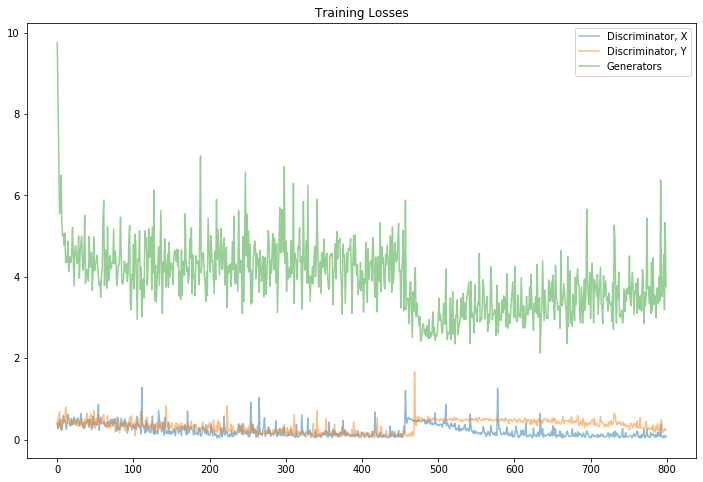

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [27]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


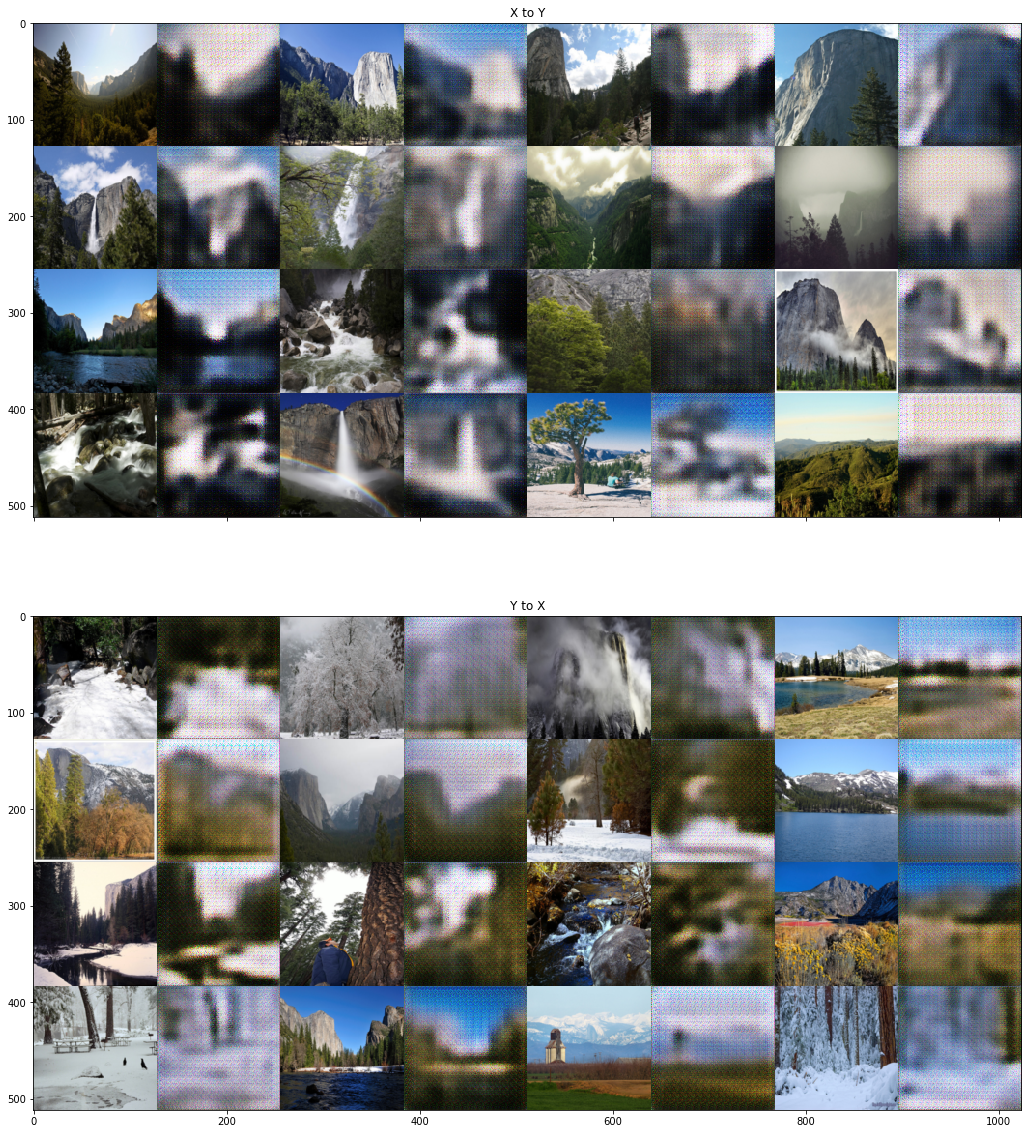

In [28]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

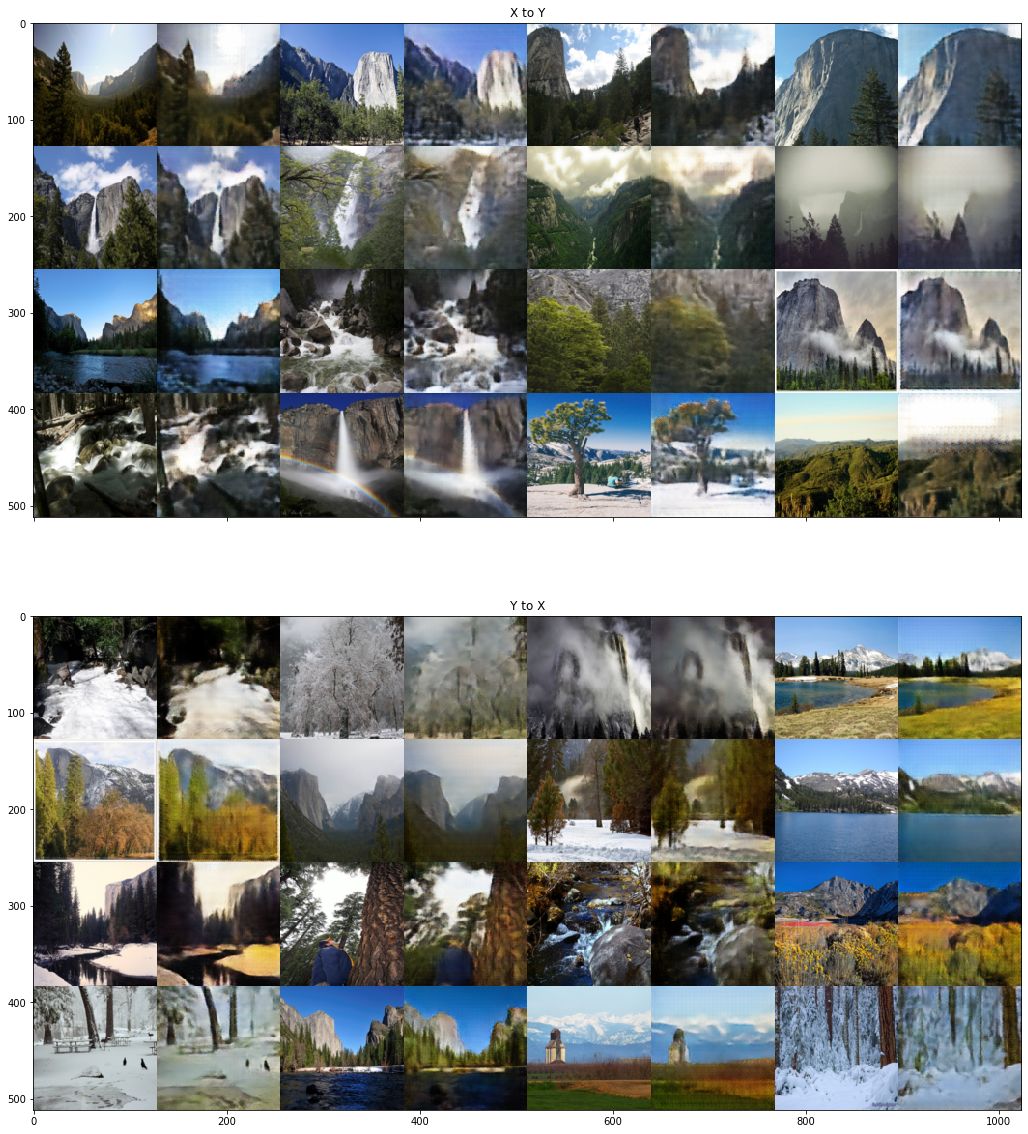

In [31]:
# view samples at iteration 4000
view_samples(8000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.